In [1]:
# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.models import Model

import keras

from sklearn.utils import class_weight

# others
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import rankdata

# for confusion matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# filter warning

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
plt.style.use('ggplot')

## CNN as classifier

We are going to built a CNN to receive the remote sensing data as input and the point measurements in binary form (Rain/No rain) as output.

# Stations:

In [3]:
# load GoogleDrive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)  # access from Google Drive

folder = './gdrive/My Drive/Deep-Learning/'

# locations

locations = pd.read_csv(folder+'stations.txt', sep=' ', index_col=0)

locations.head(20)

Mounted at /content/gdrive


,database,station_latitude(dec.degree),station_longitude(dec.degree),station_altitude(m)
station_name,,,,
TILLABERI,AMMA-CATCH,14.204300,1.454500,212.0
TOBRE,AMMA-CATCH,10.199100,2.133500,371.0
TARA,AMMA-CATCH,15.251400,-1.585500,335.0
AGOUFOU,AMMA-CATCH,15.360000,-1.470000,340.0
LAWRA,MARLOES,10.866670,-1.483330,305.0
NAVRONGO,MARLOES,10.530000,-1.050000,201.3
OUAHIGOUYA,MARLOES,13.520000,-2.390000,365.0
TAMALE,MARLOES,9.330000,-0.510000,183.3
WA,MARLOES,10.030000,-2.090000,322.7


## Load all stations out of three different datasets (CMORPH, TAMSAT, IMERG)

The resolutions have been adjusted:
1. TAMSAT: 224x224 pixels --> 7x7 averages --> 32x32 at 0.2625 degrees resolution
2. IMERG: 96x96 pixels --> 3x3 averages --> 32x32 at 0.30 degrees resolution
3. CMORPH: 32x32 pixels at 0.25 degrees resolution

1. Tillaberi

In [ ]:
# load the point-measured time-series:

gauge_TILLABERI = pd.read_csv(folder+'stationTILLABERI.csv', index_col=0)



# load the 32x32 satellite-based time-series:

TILLABERI_cmorph = pd.read_csv(folder+'CMORPH_TILLABERI32x32.csv', index_col=0)
# TILLABERI_cmorph.index = pd.to_datetime(TILLABERI_cmorph.index, errors='coerce')

TILLABERI_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_TILLABERI224x224.csv', index_col=0)
# TILLABERI_tamsat.index = pd.to_datetime(TILLABERI_tamsat.index, errors='coerce')

TILLABERI_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_TILLABERI96x96_average_to_32x32.csv', index_col=0)
# TILLABERI_imerg.index = pd.to_datetime(TILLABERI_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', TILLABERI_cmorph.shape)
print('TAMSAT:', TILLABERI_tamsat.shape)
print(' IMERG:', TILLABERI_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(TILLABERI_cmorph.index, TILLABERI_tamsat.index)  # , sat_TILLABERI_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, TILLABERI_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

TILLABERI_cmorph = TILLABERI_cmorph.loc[idx]
TILLABERI_tamsat = TILLABERI_tamsat.loc[idx]
TILLABERI_imerg  = TILLABERI_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', TILLABERI_cmorph.shape)
print('TAMSAT:', TILLABERI_tamsat.shape)
print(' IMERG:', TILLABERI_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
TILLABERI_cmorph = gauge_TILLABERI.merge(TILLABERI_cmorph, how='left', left_on=gauge_TILLABERI.index, right_on=TILLABERI_cmorph.index)
TILLABERI_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
TILLABERI_cmorph.set_index('Date', inplace=True)
TILLABERI_cmorph = TILLABERI_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
TILLABERI_cmorph.index = pd.to_datetime(TILLABERI_cmorph.index, errors='coerce')
TILLABERI_cmorph['latitude'] = locations['station_latitude(dec.degree)'][0]


# TAMSAT
TILLABERI_tamsat = gauge_TILLABERI.merge(TILLABERI_tamsat, how='left', left_on=gauge_TILLABERI.index, right_on=TILLABERI_tamsat.index)
TILLABERI_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
TILLABERI_tamsat.set_index('Date', inplace=True)
TILLABERI_tamsat = TILLABERI_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
TILLABERI_tamsat.index = pd.to_datetime(TILLABERI_tamsat.index, errors='coerce')
TILLABERI_tamsat['latitude'] = locations['station_latitude(dec.degree)'][0]


# IMERG
TILLABERI_imerg = gauge_TILLABERI.merge(TILLABERI_imerg, how='left', left_on=gauge_TILLABERI.index, right_on=TILLABERI_imerg.index)
TILLABERI_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
TILLABERI_imerg.set_index('Date', inplace=True)
TILLABERI_imerg = TILLABERI_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
TILLABERI_imerg.index = pd.to_datetime(TILLABERI_imerg.index, errors='coerce')
TILLABERI_imerg['latitude'] = locations['station_latitude(dec.degree)'][0]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', TILLABERI_cmorph.shape)
print('TAMSAT:', TILLABERI_tamsat.shape)
print(' IMERG:', TILLABERI_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1026)
TAMSAT: (2558, 1026)
 IMERG: (2558, 1026)


2. Tobre

In [ ]:
# load the point-measured time-series:

gauge_TOBRE = pd.read_csv(folder+'stationTOBRE.csv', index_col=0)


# load the 32x32 satellite-based time-series:

TOBRE_cmorph = pd.read_csv(folder+'CMORPH_TOBRE32x32.csv', index_col=0)
# TOBRE_cmorph.index = pd.to_datetime(TOBRE_cmorph.index, errors='coerce')

TOBRE_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_TOBRE224x224.csv', index_col=0)
# TOBRE_tamsat.index = pd.to_datetime(TOBRE_tamsat.index, errors='coerce')

TOBRE_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_TOBRE96x96_average_to_32x32.csv', index_col=0)
# TOBRE_imerg.index = pd.to_datetime(TOBRE_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', TOBRE_cmorph.shape)
print('TAMSAT:', TOBRE_tamsat.shape)
print(' IMERG:', TOBRE_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(TOBRE_cmorph.index, TOBRE_tamsat.index)  # , sat_TOBRE_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, TOBRE_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

TOBRE_cmorph = TOBRE_cmorph.loc[idx]
TOBRE_tamsat = TOBRE_tamsat.loc[idx]
TOBRE_imerg  = TOBRE_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', TOBRE_cmorph.shape)
print('TAMSAT:', TOBRE_tamsat.shape)
print(' IMERG:', TOBRE_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
TOBRE_cmorph = gauge_TOBRE.merge(TOBRE_cmorph, how='left', left_on=gauge_TOBRE.index, right_on=TOBRE_cmorph.index)
TOBRE_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
TOBRE_cmorph.set_index('Date', inplace=True)
TOBRE_cmorph = TOBRE_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
TOBRE_cmorph.index = pd.to_datetime(TOBRE_cmorph.index, errors='coerce')
TOBRE_cmorph['latitude'] = locations['station_latitude(dec.degree)'][1]


# TAMSAT
TOBRE_tamsat = gauge_TOBRE.merge(TOBRE_tamsat, how='left', left_on=gauge_TOBRE.index, right_on=TOBRE_tamsat.index)
TOBRE_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
TOBRE_tamsat.set_index('Date', inplace=True)
TOBRE_tamsat = TOBRE_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
TOBRE_tamsat.index = pd.to_datetime(TOBRE_tamsat.index, errors='coerce')
TOBRE_tamsat['latitude'] = locations['station_latitude(dec.degree)'][1]


# IMERG
TOBRE_imerg = gauge_TOBRE.merge(TOBRE_imerg, how='left', left_on=gauge_TOBRE.index, right_on=TOBRE_imerg.index)
TOBRE_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
TOBRE_imerg.set_index('Date', inplace=True)
TOBRE_imerg = TOBRE_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
TOBRE_imerg.index = pd.to_datetime(TOBRE_imerg.index, errors='coerce')
TOBRE_imerg['latitude'] = locations['station_latitude(dec.degree)'][1]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', TOBRE_cmorph.shape)
print('TAMSAT:', TOBRE_tamsat.shape)
print(' IMERG:', TOBRE_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2247, 1026)
TAMSAT: (2247, 1026)
 IMERG: (2247, 1026)


3. Tara

In [ ]:
# load the point-measured time-series:

gauge_TARA = pd.read_csv(folder+'stationTARA.csv', index_col=0)


# load the 32x32 satellite-based time-series:

TARA_cmorph = pd.read_csv(folder+'CMORPH_TARA32x32.csv', index_col=0)
# TARA_cmorph.index = pd.to_datetime(TARA_cmorph.index, errors='coerce')

TARA_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_TARA224x224.csv', index_col=0)
# TARA_tamsat.index = pd.to_datetime(TARA_tamsat.index, errors='coerce')

TARA_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_TARA96x96_average_to_32x32.csv', index_col=0)
# TARA_imerg.index = pd.to_datetime(TARA_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', TARA_cmorph.shape)
print('TAMSAT:', TARA_tamsat.shape)
print(' IMERG:', TARA_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(TARA_cmorph.index, TARA_tamsat.index)  # , sat_TARA_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, TARA_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

TARA_cmorph = TARA_cmorph.loc[idx]
TARA_tamsat = TARA_tamsat.loc[idx]
TARA_imerg  = TARA_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', TARA_cmorph.shape)
print('TAMSAT:', TARA_tamsat.shape)
print(' IMERG:', TARA_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
TARA_cmorph = gauge_TARA.merge(TARA_cmorph, how='left', left_on=gauge_TARA.index, right_on=TARA_cmorph.index)
TARA_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
TARA_cmorph.set_index('Date', inplace=True)
TARA_cmorph = TARA_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
TARA_cmorph.index = pd.to_datetime(TARA_cmorph.index, errors='coerce')
TARA_cmorph['latitude'] = locations['station_latitude(dec.degree)'][2]


# TAMSAT
TARA_tamsat = gauge_TARA.merge(TARA_tamsat, how='left', left_on=gauge_TARA.index, right_on=TARA_tamsat.index)
TARA_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
TARA_tamsat.set_index('Date', inplace=True)
TARA_tamsat = TARA_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
TARA_tamsat.index = pd.to_datetime(TARA_tamsat.index, errors='coerce')
TARA_tamsat['latitude'] = locations['station_latitude(dec.degree)'][2]


# IMERG
TARA_imerg = gauge_TARA.merge(TARA_imerg, how='left', left_on=gauge_TARA.index, right_on=TARA_imerg.index)
TARA_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
TARA_imerg.set_index('Date', inplace=True)
TARA_imerg = TARA_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
TARA_imerg.index = pd.to_datetime(TARA_imerg.index, errors='coerce')
TARA_imerg['latitude'] = locations['station_latitude(dec.degree)'][2]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', TARA_cmorph.shape)
print('TAMSAT:', TARA_tamsat.shape)
print(' IMERG:', TARA_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (1826, 1026)
TAMSAT: (1826, 1026)
 IMERG: (1826, 1026)


4. Agoufou

In [ ]:
# load the point-measured time-series:

gauge_AGOUFOU = pd.read_csv(folder+'stationAGOUFOU.csv', index_col=0)


# load the 32x32 satellite-based time-series:

AGOUFOU_cmorph = pd.read_csv(folder+'CMORPH_AGOUFOU32x32.csv', index_col=0)
# AGOUFOU_cmorph.index = pd.to_datetime(AGOUFOU_cmorph.index, errors='coerce')

AGOUFOU_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_AGOUFOU224x224.csv', index_col=0)
# AGOUFOU_tamsat.index = pd.to_datetime(AGOUFOU_tamsat.index, errors='coerce')

AGOUFOU_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_AGOUFOU96x96_average_to_32x32.csv', index_col=0)
# AGOUFOU_imerg.index = pd.to_datetime(AGOUFOU_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', AGOUFOU_cmorph.shape)
print('TAMSAT:', AGOUFOU_tamsat.shape)
print(' IMERG:', AGOUFOU_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(AGOUFOU_cmorph.index, AGOUFOU_tamsat.index)  # , sat_AGOUFOU_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, AGOUFOU_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

AGOUFOU_cmorph = AGOUFOU_cmorph.loc[idx]
AGOUFOU_tamsat = AGOUFOU_tamsat.loc[idx]
AGOUFOU_imerg  = AGOUFOU_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', AGOUFOU_cmorph.shape)
print('TAMSAT:', AGOUFOU_tamsat.shape)
print(' IMERG:', AGOUFOU_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
AGOUFOU_cmorph = gauge_AGOUFOU.merge(AGOUFOU_cmorph, how='left', left_on=gauge_AGOUFOU.index, right_on=AGOUFOU_cmorph.index)
AGOUFOU_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
AGOUFOU_cmorph.set_index('Date', inplace=True)
AGOUFOU_cmorph = AGOUFOU_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
AGOUFOU_cmorph.index = pd.to_datetime(AGOUFOU_cmorph.index, errors='coerce')
AGOUFOU_cmorph['latitude'] = locations['station_latitude(dec.degree)'][3]


# TAMSAT
AGOUFOU_tamsat = gauge_AGOUFOU.merge(AGOUFOU_tamsat, how='left', left_on=gauge_AGOUFOU.index, right_on=AGOUFOU_tamsat.index)
AGOUFOU_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
AGOUFOU_tamsat.set_index('Date', inplace=True)
AGOUFOU_tamsat = AGOUFOU_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
AGOUFOU_tamsat.index = pd.to_datetime(AGOUFOU_tamsat.index, errors='coerce')
AGOUFOU_tamsat['latitude'] = locations['station_latitude(dec.degree)'][3]


# IMERG
AGOUFOU_imerg = gauge_AGOUFOU.merge(AGOUFOU_imerg, how='left', left_on=gauge_AGOUFOU.index, right_on=AGOUFOU_imerg.index)
AGOUFOU_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
AGOUFOU_imerg.set_index('Date', inplace=True)
AGOUFOU_imerg = AGOUFOU_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
AGOUFOU_imerg.index = pd.to_datetime(AGOUFOU_imerg.index, errors='coerce')
AGOUFOU_imerg['latitude'] = locations['station_latitude(dec.degree)'][3]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', AGOUFOU_cmorph.shape)
print('TAMSAT:', AGOUFOU_tamsat.shape)
print(' IMERG:', AGOUFOU_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2132, 1026)
TAMSAT: (2132, 1026)
 IMERG: (2132, 1026)


5. Lawra

In [ ]:
# load the point-measured time-series:

gauge_LAWRA = pd.read_csv(folder+'stationLAWRA.csv', index_col=0)


# load the 32x32 satellite-based time-series:

LAWRA_cmorph = pd.read_csv(folder+'CMORPH_LAWRA32x32.csv', index_col=0)
# LAWRA_cmorph.index = pd.to_datetime(LAWRA_cmorph.index, errors='coerce')

LAWRA_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_LAWRA224x224.csv', index_col=0)
# LAWRA_tamsat.index = pd.to_datetime(LAWRA_tamsat.index, errors='coerce')

LAWRA_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_LAWRA96x96_average_to_32x32.csv', index_col=0)
# LAWRA_imerg.index = pd.to_datetime(LAWRA_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', LAWRA_cmorph.shape)
print('TAMSAT:', LAWRA_tamsat.shape)
print(' IMERG:', LAWRA_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(LAWRA_cmorph.index, LAWRA_tamsat.index)  # , sat_LAWRA_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, LAWRA_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

LAWRA_cmorph = LAWRA_cmorph.loc[idx]
LAWRA_tamsat = LAWRA_tamsat.loc[idx]
LAWRA_imerg  = LAWRA_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', LAWRA_cmorph.shape)
print('TAMSAT:', LAWRA_tamsat.shape)
print(' IMERG:', LAWRA_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
LAWRA_cmorph = gauge_LAWRA.merge(LAWRA_cmorph, how='left', left_on=gauge_LAWRA.index, right_on=LAWRA_cmorph.index)
LAWRA_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
LAWRA_cmorph.set_index('Date', inplace=True)
LAWRA_cmorph = LAWRA_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
LAWRA_cmorph.index = pd.to_datetime(LAWRA_cmorph.index, errors='coerce')
LAWRA_cmorph['latitude'] = locations['station_latitude(dec.degree)'][4]


# TAMSAT
LAWRA_tamsat = gauge_LAWRA.merge(LAWRA_tamsat, how='left', left_on=gauge_LAWRA.index, right_on=LAWRA_tamsat.index)
LAWRA_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
LAWRA_tamsat.set_index('Date', inplace=True)
LAWRA_tamsat = LAWRA_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
LAWRA_tamsat.index = pd.to_datetime(LAWRA_tamsat.index, errors='coerce')
LAWRA_tamsat['latitude'] = locations['station_latitude(dec.degree)'][4]


# IMERG
LAWRA_imerg = gauge_LAWRA.merge(LAWRA_imerg, how='left', left_on=gauge_LAWRA.index, right_on=LAWRA_imerg.index)
LAWRA_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
LAWRA_imerg.set_index('Date', inplace=True)
LAWRA_imerg = LAWRA_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
LAWRA_imerg.index = pd.to_datetime(LAWRA_imerg.index, errors='coerce')
LAWRA_imerg['latitude'] = locations['station_latitude(dec.degree)'][4]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', LAWRA_cmorph.shape)
print('TAMSAT:', LAWRA_tamsat.shape)
print(' IMERG:', LAWRA_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (330, 1026)
TAMSAT: (330, 1026)
 IMERG: (330, 1026)


6. Navrongo

In [ ]:
# load the point-measured time-series:

gauge_NAVRONGO = pd.read_csv(folder+'stationNAVRONGO.csv', index_col=0)


# load the 32x32 satellite-based time-series:

NAVRONGO_cmorph = pd.read_csv(folder+'CMORPH_NAVRONGO32x32.csv', index_col=0)
# NAVRONGO_cmorph.index = pd.to_datetime(NAVRONGO_cmorph.index, errors='coerce')

NAVRONGO_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_NAVRONGO224x224.csv', index_col=0)
# NAVRONGO_tamsat.index = pd.to_datetime(NAVRONGO_tamsat.index, errors='coerce')

NAVRONGO_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_NAVRONGO96x96_average_to_32x32.csv', index_col=0)
# NAVRONGO_imerg.index = pd.to_datetime(NAVRONGO_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', NAVRONGO_cmorph.shape)
print('TAMSAT:', NAVRONGO_tamsat.shape)
print(' IMERG:', NAVRONGO_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(NAVRONGO_cmorph.index, NAVRONGO_tamsat.index)  # , sat_NAVRONGO_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, NAVRONGO_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

NAVRONGO_cmorph = NAVRONGO_cmorph.loc[idx]
NAVRONGO_tamsat = NAVRONGO_tamsat.loc[idx]
NAVRONGO_imerg  = NAVRONGO_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', NAVRONGO_cmorph.shape)
print('TAMSAT:', NAVRONGO_tamsat.shape)
print(' IMERG:', NAVRONGO_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
NAVRONGO_cmorph = gauge_NAVRONGO.merge(NAVRONGO_cmorph, how='left', left_on=gauge_NAVRONGO.index, right_on=NAVRONGO_cmorph.index)
NAVRONGO_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
NAVRONGO_cmorph.set_index('Date', inplace=True)
NAVRONGO_cmorph = NAVRONGO_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
NAVRONGO_cmorph.index = pd.to_datetime(NAVRONGO_cmorph.index, errors='coerce')
NAVRONGO_cmorph['latitude'] = locations['station_latitude(dec.degree)'][5]


# TAMSAT
NAVRONGO_tamsat = gauge_NAVRONGO.merge(NAVRONGO_tamsat, how='left', left_on=gauge_NAVRONGO.index, right_on=NAVRONGO_tamsat.index)
NAVRONGO_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
NAVRONGO_tamsat.set_index('Date', inplace=True)
NAVRONGO_tamsat = NAVRONGO_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
NAVRONGO_tamsat.index = pd.to_datetime(NAVRONGO_tamsat.index, errors='coerce')
NAVRONGO_tamsat['latitude'] = locations['station_latitude(dec.degree)'][5]


# IMERG
NAVRONGO_imerg = gauge_NAVRONGO.merge(NAVRONGO_imerg, how='left', left_on=gauge_NAVRONGO.index, right_on=NAVRONGO_imerg.index)
NAVRONGO_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
NAVRONGO_imerg.set_index('Date', inplace=True)
NAVRONGO_imerg = NAVRONGO_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
NAVRONGO_imerg.index = pd.to_datetime(NAVRONGO_imerg.index, errors='coerce')
NAVRONGO_imerg['latitude'] = locations['station_latitude(dec.degree)'][5]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', NAVRONGO_cmorph.shape)
print('TAMSAT:', NAVRONGO_tamsat.shape)
print(' IMERG:', NAVRONGO_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (1212, 1026)
TAMSAT: (1212, 1026)
 IMERG: (1212, 1026)


7. Ouahigouya

In [ ]:
# load the point-measured time-series:

gauge_OUAHIGOUYA = pd.read_csv(folder+'stationOUAHIGOUYA.csv', index_col=0)


# load the 32x32 satellite-based time-series:

OUAHIGOUYA_cmorph = pd.read_csv(folder+'CMORPH_OUAHIGOUYA32x32.csv', index_col=0)
# OUAHIGOUYA_cmorph.index = pd.to_datetime(OUAHIGOUYA_cmorph.index, errors='coerce')

OUAHIGOUYA_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_OUAHIGOUYA224x224.csv', index_col=0)
# OUAHIGOUYA_tamsat.index = pd.to_datetime(OUAHIGOUYA_tamsat.index, errors='coerce')

OUAHIGOUYA_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_OUAHIGOUYA96x96_average_to_32x32.csv', index_col=0)
# OUAHIGOUYA_imerg.index = pd.to_datetime(OUAHIGOUYA_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', OUAHIGOUYA_cmorph.shape)
print('TAMSAT:', OUAHIGOUYA_tamsat.shape)
print(' IMERG:', OUAHIGOUYA_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(OUAHIGOUYA_cmorph.index, OUAHIGOUYA_tamsat.index)  # , sat_OUAHIGOUYA_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, OUAHIGOUYA_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

OUAHIGOUYA_cmorph = OUAHIGOUYA_cmorph.loc[idx]
OUAHIGOUYA_tamsat = OUAHIGOUYA_tamsat.loc[idx]
OUAHIGOUYA_imerg  = OUAHIGOUYA_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', OUAHIGOUYA_cmorph.shape)
print('TAMSAT:', OUAHIGOUYA_tamsat.shape)
print(' IMERG:', OUAHIGOUYA_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
OUAHIGOUYA_cmorph = gauge_OUAHIGOUYA.merge(OUAHIGOUYA_cmorph, how='left', left_on=gauge_OUAHIGOUYA.index, right_on=OUAHIGOUYA_cmorph.index)
OUAHIGOUYA_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
OUAHIGOUYA_cmorph.set_index('Date', inplace=True)
OUAHIGOUYA_cmorph = OUAHIGOUYA_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
OUAHIGOUYA_cmorph.index = pd.to_datetime(OUAHIGOUYA_cmorph.index, errors='coerce')
OUAHIGOUYA_cmorph['latitude'] = locations['station_latitude(dec.degree)'][6]


# TAMSAT
OUAHIGOUYA_tamsat = gauge_OUAHIGOUYA.merge(OUAHIGOUYA_tamsat, how='left', left_on=gauge_OUAHIGOUYA.index, right_on=OUAHIGOUYA_tamsat.index)
OUAHIGOUYA_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
OUAHIGOUYA_tamsat.set_index('Date', inplace=True)
OUAHIGOUYA_tamsat = OUAHIGOUYA_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
OUAHIGOUYA_tamsat.index = pd.to_datetime(OUAHIGOUYA_tamsat.index, errors='coerce')
OUAHIGOUYA_tamsat['latitude'] = locations['station_latitude(dec.degree)'][6]


# IMERG
OUAHIGOUYA_imerg = gauge_OUAHIGOUYA.merge(OUAHIGOUYA_imerg, how='left', left_on=gauge_OUAHIGOUYA.index, right_on=OUAHIGOUYA_imerg.index)
OUAHIGOUYA_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
OUAHIGOUYA_imerg.set_index('Date', inplace=True)
OUAHIGOUYA_imerg = OUAHIGOUYA_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
OUAHIGOUYA_imerg.index = pd.to_datetime(OUAHIGOUYA_imerg.index, errors='coerce')
OUAHIGOUYA_imerg['latitude'] = locations['station_latitude(dec.degree)'][6]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', OUAHIGOUYA_cmorph.shape)
print('TAMSAT:', OUAHIGOUYA_tamsat.shape)
print(' IMERG:', OUAHIGOUYA_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (1487, 1026)
TAMSAT: (1487, 1026)
 IMERG: (1487, 1026)


8. Tamale

In [ ]:
# load the point-measured time-series:

gauge_TAMALE = pd.read_csv(folder+'stationTAMALE.csv', index_col=0)


# load the 32x32 satellite-based time-series:

TAMALE_cmorph = pd.read_csv(folder+'CMORPH_TAMALE32x32.csv', index_col=0)
# TAMALE_cmorph.index = pd.to_datetime(TAMALE_cmorph.index, errors='coerce')

TAMALE_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_TAMALE224x224.csv', index_col=0)
# TAMALE_tamsat.index = pd.to_datetime(TAMALE_tamsat.index, errors='coerce')

TAMALE_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_TAMALE96x96_average_to_32x32.csv', index_col=0)
# TAMALE_imerg.index = pd.to_datetime(TAMALE_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', TAMALE_cmorph.shape)
print('TAMSAT:', TAMALE_tamsat.shape)
print(' IMERG:', TAMALE_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(TAMALE_cmorph.index, TAMALE_tamsat.index)  # , sat_TAMALE_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, TAMALE_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

TAMALE_cmorph = TAMALE_cmorph.loc[idx]
TAMALE_tamsat = TAMALE_tamsat.loc[idx]
TAMALE_imerg  = TAMALE_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', TAMALE_cmorph.shape)
print('TAMSAT:', TAMALE_tamsat.shape)
print(' IMERG:', TAMALE_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
TAMALE_cmorph = gauge_TAMALE.merge(TAMALE_cmorph, how='left', left_on=gauge_TAMALE.index, right_on=TAMALE_cmorph.index)
TAMALE_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
TAMALE_cmorph.set_index('Date', inplace=True)
TAMALE_cmorph = TAMALE_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
TAMALE_cmorph.index = pd.to_datetime(TAMALE_cmorph.index, errors='coerce')
TAMALE_cmorph['latitude'] = locations['station_latitude(dec.degree)'][7]


# TAMSAT
TAMALE_tamsat = gauge_TAMALE.merge(TAMALE_tamsat, how='left', left_on=gauge_TAMALE.index, right_on=TAMALE_tamsat.index)
TAMALE_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
TAMALE_tamsat.set_index('Date', inplace=True)
TAMALE_tamsat = TAMALE_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
TAMALE_tamsat.index = pd.to_datetime(TAMALE_tamsat.index, errors='coerce')
TAMALE_tamsat['latitude'] = locations['station_latitude(dec.degree)'][7]


# IMERG
TAMALE_imerg = gauge_TAMALE.merge(TAMALE_imerg, how='left', left_on=gauge_TAMALE.index, right_on=TAMALE_imerg.index)
TAMALE_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
TAMALE_imerg.set_index('Date', inplace=True)
TAMALE_imerg = TAMALE_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
TAMALE_imerg.index = pd.to_datetime(TAMALE_imerg.index, errors='coerce')
TAMALE_imerg['latitude'] = locations['station_latitude(dec.degree)'][7]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', TAMALE_cmorph.shape)
print('TAMSAT:', TAMALE_tamsat.shape)
print(' IMERG:', TAMALE_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (1334, 1026)
TAMSAT: (1334, 1026)
 IMERG: (1334, 1026)


9. Wa

In [ ]:
# load the point-measured time-series:

gauge_WA = pd.read_csv(folder+'stationWA.csv', index_col=0)


# load the 32x32 satellite-based time-series:

WA_cmorph = pd.read_csv(folder+'CMORPH_WA32x32.csv', index_col=0)
# WA_cmorph.index = pd.to_datetime(WA_cmorph.index, errors='coerce')

WA_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_WA224x224.csv', index_col=0)
# WA_tamsat.index = pd.to_datetime(WA_tamsat.index, errors='coerce')

WA_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_WA96x96_average_to_32x32.csv', index_col=0)
# WA_imerg.index = pd.to_datetime(WA_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', WA_cmorph.shape)
print('TAMSAT:', WA_tamsat.shape)
print(' IMERG:', WA_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(WA_cmorph.index, WA_tamsat.index)  # , sat_WA_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, WA_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

WA_cmorph = WA_cmorph.loc[idx]
WA_tamsat = WA_tamsat.loc[idx]
WA_imerg  = WA_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', WA_cmorph.shape)
print('TAMSAT:', WA_tamsat.shape)
print(' IMERG:', WA_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
WA_cmorph = gauge_WA.merge(WA_cmorph, how='left', left_on=gauge_WA.index, right_on=WA_cmorph.index)
WA_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
WA_cmorph.set_index('Date', inplace=True)
WA_cmorph = WA_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
WA_cmorph.index = pd.to_datetime(WA_cmorph.index, errors='coerce')
WA_cmorph['latitude'] = locations['station_latitude(dec.degree)'][8]


# TAMSAT
WA_tamsat = gauge_WA.merge(WA_tamsat, how='left', left_on=gauge_WA.index, right_on=WA_tamsat.index)
WA_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
WA_tamsat.set_index('Date', inplace=True)
WA_tamsat = WA_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
WA_tamsat.index = pd.to_datetime(WA_tamsat.index, errors='coerce')
WA_tamsat['latitude'] = locations['station_latitude(dec.degree)'][8]


# IMERG
WA_imerg = gauge_WA.merge(WA_imerg, how='left', left_on=gauge_WA.index, right_on=WA_imerg.index)
WA_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
WA_imerg.set_index('Date', inplace=True)
WA_imerg = WA_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
WA_imerg.index = pd.to_datetime(WA_imerg.index, errors='coerce')
WA_imerg['latitude'] = locations['station_latitude(dec.degree)'][8]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', WA_cmorph.shape)
print('TAMSAT:', WA_tamsat.shape)
print(' IMERG:', WA_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (727, 1026)
TAMSAT: (727, 1026)
 IMERG: (727, 1026)


10. Zuarungu

In [ ]:
# load the point-measured time-series:

gauge_ZUARUNGU = pd.read_csv(folder+'stationZUARUNGU.csv', index_col=0)


# load the 32x32 satellite-based time-series:

ZUARUNGU_cmorph = pd.read_csv(folder+'CMORPH_ZUARUNGU32x32.csv', index_col=0)
# ZUARUNGU_cmorph.index = pd.to_datetime(ZUARUNGU_cmorph.index, errors='coerce')

ZUARUNGU_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_ZUARUNGU224x224.csv', index_col=0)
# ZUARUNGU_tamsat.index = pd.to_datetime(ZUARUNGU_tamsat.index, errors='coerce')

ZUARUNGU_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_ZUARUNGU96x96_average_to_32x32.csv', index_col=0)
# ZUARUNGU_imerg.index = pd.to_datetime(ZUARUNGU_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', ZUARUNGU_cmorph.shape)
print('TAMSAT:', ZUARUNGU_tamsat.shape)
print(' IMERG:', ZUARUNGU_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(ZUARUNGU_cmorph.index, ZUARUNGU_tamsat.index)  # , sat_ZUARUNGU_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, ZUARUNGU_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

ZUARUNGU_cmorph = ZUARUNGU_cmorph.loc[idx]
ZUARUNGU_tamsat = ZUARUNGU_tamsat.loc[idx]
ZUARUNGU_imerg  = ZUARUNGU_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', ZUARUNGU_cmorph.shape)
print('TAMSAT:', ZUARUNGU_tamsat.shape)
print(' IMERG:', ZUARUNGU_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
ZUARUNGU_cmorph = gauge_ZUARUNGU.merge(ZUARUNGU_cmorph, how='left', left_on=gauge_ZUARUNGU.index, right_on=ZUARUNGU_cmorph.index)
ZUARUNGU_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
ZUARUNGU_cmorph.set_index('Date', inplace=True)
ZUARUNGU_cmorph = ZUARUNGU_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
ZUARUNGU_cmorph.index = pd.to_datetime(ZUARUNGU_cmorph.index, errors='coerce')
ZUARUNGU_cmorph['latitude'] = locations['station_latitude(dec.degree)'][9]


# TAMSAT
ZUARUNGU_tamsat = gauge_ZUARUNGU.merge(ZUARUNGU_tamsat, how='left', left_on=gauge_ZUARUNGU.index, right_on=ZUARUNGU_tamsat.index)
ZUARUNGU_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
ZUARUNGU_tamsat.set_index('Date', inplace=True)
ZUARUNGU_tamsat = ZUARUNGU_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
ZUARUNGU_tamsat.index = pd.to_datetime(ZUARUNGU_tamsat.index, errors='coerce')
ZUARUNGU_tamsat['latitude'] = locations['station_latitude(dec.degree)'][9]


# IMERG
ZUARUNGU_imerg = gauge_ZUARUNGU.merge(ZUARUNGU_imerg, how='left', left_on=gauge_ZUARUNGU.index, right_on=ZUARUNGU_imerg.index)
ZUARUNGU_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
ZUARUNGU_imerg.set_index('Date', inplace=True)
ZUARUNGU_imerg = ZUARUNGU_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
ZUARUNGU_imerg.index = pd.to_datetime(ZUARUNGU_imerg.index, errors='coerce')
ZUARUNGU_imerg['latitude'] = locations['station_latitude(dec.degree)'][9]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', ZUARUNGU_cmorph.shape)
print('TAMSAT:', ZUARUNGU_tamsat.shape)
print(' IMERG:', ZUARUNGU_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (727, 1026)
TAMSAT: (727, 1026)
 IMERG: (727, 1026)


11. Aniabisi

In [ ]:
# load the point-measured time-series:

gauge_ANIABISI = pd.read_csv(folder+'stationANIABISI.csv', index_col=0)


# load the 32x32 satellite-based time-series:

ANIABISI_cmorph = pd.read_csv(folder+'CMORPH_ANIABISI32x32.csv', index_col=0)
# ANIABISI_cmorph.index = pd.to_datetime(ANIABISI_cmorph.index, errors='coerce')

ANIABISI_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_ANIABISI224x224.csv', index_col=0)
# ANIABISI_tamsat.index = pd.to_datetime(ANIABISI_tamsat.index, errors='coerce')

ANIABISI_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_ANIABISI96x96_average_to_32x32.csv', index_col=0)
# ANIABISI_imerg.index = pd.to_datetime(ANIABISI_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', ANIABISI_cmorph.shape)
print('TAMSAT:', ANIABISI_tamsat.shape)
print(' IMERG:', ANIABISI_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(ANIABISI_cmorph.index, ANIABISI_tamsat.index)  # , sat_ANIABISI_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, ANIABISI_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

ANIABISI_cmorph = ANIABISI_cmorph.loc[idx]
ANIABISI_tamsat = ANIABISI_tamsat.loc[idx]
ANIABISI_imerg  = ANIABISI_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', ANIABISI_cmorph.shape)
print('TAMSAT:', ANIABISI_tamsat.shape)
print(' IMERG:', ANIABISI_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
ANIABISI_cmorph = gauge_ANIABISI.merge(ANIABISI_cmorph, how='left', left_on=gauge_ANIABISI.index, right_on=ANIABISI_cmorph.index)
ANIABISI_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
ANIABISI_cmorph.set_index('Date', inplace=True)
ANIABISI_cmorph = ANIABISI_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
ANIABISI_cmorph.index = pd.to_datetime(ANIABISI_cmorph.index, errors='coerce')
ANIABISI_cmorph['latitude'] = locations['station_latitude(dec.degree)'][10]


# TAMSAT
ANIABISI_tamsat = gauge_ANIABISI.merge(ANIABISI_tamsat, how='left', left_on=gauge_ANIABISI.index, right_on=ANIABISI_tamsat.index)
ANIABISI_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
ANIABISI_tamsat.set_index('Date', inplace=True)
ANIABISI_tamsat = ANIABISI_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
ANIABISI_tamsat.index = pd.to_datetime(ANIABISI_tamsat.index, errors='coerce')
ANIABISI_tamsat['latitude'] = locations['station_latitude(dec.degree)'][10]


# IMERG
ANIABISI_imerg = gauge_ANIABISI.merge(ANIABISI_imerg, how='left', left_on=gauge_ANIABISI.index, right_on=ANIABISI_imerg.index)
ANIABISI_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
ANIABISI_imerg.set_index('Date', inplace=True)
ANIABISI_imerg = ANIABISI_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
ANIABISI_imerg.index = pd.to_datetime(ANIABISI_imerg.index, errors='coerce')
ANIABISI_imerg['latitude'] = locations['station_latitude(dec.degree)'][10]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', ANIABISI_cmorph.shape)
print('TAMSAT:', ANIABISI_tamsat.shape)
print(' IMERG:', ANIABISI_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (272, 1026)
TAMSAT: (272, 1026)
 IMERG: (272, 1026)


12. Poudri

In [ ]:
# load the point-measured time-series:

gauge_POUDRI = pd.read_csv(folder+'stationPOUDRI.csv', index_col=0)


# load the 32x32 satellite-based time-series:

POUDRI_cmorph = pd.read_csv(folder+'CMORPH_POUDRI32x32.csv', index_col=0)
# POUDRI_cmorph.index = pd.to_datetime(POUDRI_cmorph.index, errors='coerce')

POUDRI_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_POUDRI224x224.csv', index_col=0)
# POUDRI_tamsat.index = pd.to_datetime(POUDRI_tamsat.index, errors='coerce')

POUDRI_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_POUDRI96x96_average_to_32x32.csv', index_col=0)
# POUDRI_imerg.index = pd.to_datetime(POUDRI_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', POUDRI_cmorph.shape)
print('TAMSAT:', POUDRI_tamsat.shape)
print(' IMERG:', POUDRI_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(POUDRI_cmorph.index, POUDRI_tamsat.index)  # , sat_POUDRI_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, POUDRI_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

POUDRI_cmorph = POUDRI_cmorph.loc[idx]
POUDRI_tamsat = POUDRI_tamsat.loc[idx]
POUDRI_imerg  = POUDRI_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', POUDRI_cmorph.shape)
print('TAMSAT:', POUDRI_tamsat.shape)
print(' IMERG:', POUDRI_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
POUDRI_cmorph = gauge_POUDRI.merge(POUDRI_cmorph, how='left', left_on=gauge_POUDRI.index, right_on=POUDRI_cmorph.index)
POUDRI_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
POUDRI_cmorph.set_index('Date', inplace=True)
POUDRI_cmorph = POUDRI_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
POUDRI_cmorph.index = pd.to_datetime(POUDRI_cmorph.index, errors='coerce')
POUDRI_cmorph['latitude'] = locations['station_latitude(dec.degree)'][11]


# TAMSAT
POUDRI_tamsat = gauge_POUDRI.merge(POUDRI_tamsat, how='left', left_on=gauge_POUDRI.index, right_on=POUDRI_tamsat.index)
POUDRI_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
POUDRI_tamsat.set_index('Date', inplace=True)
POUDRI_tamsat = POUDRI_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
POUDRI_tamsat.index = pd.to_datetime(POUDRI_tamsat.index, errors='coerce')
POUDRI_tamsat['latitude'] = locations['station_latitude(dec.degree)'][11]


# IMERG
POUDRI_imerg = gauge_POUDRI.merge(POUDRI_imerg, how='left', left_on=gauge_POUDRI.index, right_on=POUDRI_imerg.index)
POUDRI_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
POUDRI_imerg.set_index('Date', inplace=True)
POUDRI_imerg = POUDRI_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
POUDRI_imerg.index = pd.to_datetime(POUDRI_imerg.index, errors='coerce')
POUDRI_imerg['latitude'] = locations['station_latitude(dec.degree)'][11]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', POUDRI_cmorph.shape)
print('TAMSAT:', POUDRI_tamsat.shape)
print(' IMERG:', POUDRI_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (404, 1026)
TAMSAT: (404, 1026)
 IMERG: (404, 1026)


13. Lare

In [ ]:
# load the point-measured time-series:

gauge_LARE = pd.read_csv(folder+'stationLARE.csv', index_col=0)


# load the 32x32 satellite-based time-series:

LARE_cmorph = pd.read_csv(folder+'CMORPH_LARE32x32.csv', index_col=0)
# LARE_cmorph.index = pd.to_datetime(LARE_cmorph.index, errors='coerce')

LARE_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_LARE224x224.csv', index_col=0)
# LARE_tamsat.index = pd.to_datetime(LARE_tamsat.index, errors='coerce')

LARE_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_LARE96x96_average_to_32x32.csv', index_col=0)
# LARE_imerg.index = pd.to_datetime(LARE_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', LARE_cmorph.shape)
print('TAMSAT:', LARE_tamsat.shape)
print(' IMERG:', LARE_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(LARE_cmorph.index, LARE_tamsat.index)  # , sat_LARE_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, LARE_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

LARE_cmorph = LARE_cmorph.loc[idx]
LARE_tamsat = LARE_tamsat.loc[idx]
LARE_imerg  = LARE_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', LARE_cmorph.shape)
print('TAMSAT:', LARE_tamsat.shape)
print(' IMERG:', LARE_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
LARE_cmorph = gauge_LARE.merge(LARE_cmorph, how='left', left_on=gauge_LARE.index, right_on=LARE_cmorph.index)
LARE_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
LARE_cmorph.set_index('Date', inplace=True)
LARE_cmorph = LARE_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
LARE_cmorph.index = pd.to_datetime(LARE_cmorph.index, errors='coerce')
LARE_cmorph['latitude'] = locations['station_latitude(dec.degree)'][12]


# TAMSAT
LARE_tamsat = gauge_LARE.merge(LARE_tamsat, how='left', left_on=gauge_LARE.index, right_on=LARE_tamsat.index)
LARE_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
LARE_tamsat.set_index('Date', inplace=True)
LARE_tamsat = LARE_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
LARE_tamsat.index = pd.to_datetime(LARE_tamsat.index, errors='coerce')
LARE_tamsat['latitude'] = locations['station_latitude(dec.degree)'][12]


# IMERG
LARE_imerg = gauge_LARE.merge(LARE_imerg, how='left', left_on=gauge_LARE.index, right_on=LARE_imerg.index)
LARE_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
LARE_imerg.set_index('Date', inplace=True)
LARE_imerg = LARE_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
LARE_imerg.index = pd.to_datetime(LARE_imerg.index, errors='coerce')
LARE_imerg['latitude'] = locations['station_latitude(dec.degree)'][12]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', LARE_cmorph.shape)
print('TAMSAT:', LARE_tamsat.shape)
print(' IMERG:', LARE_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (311, 1026)
TAMSAT: (311, 1026)
 IMERG: (311, 1026)


14. Yabogane

In [ ]:
# load the point-measured time-series:

gauge_YABOGANE = pd.read_csv(folder+'stationYABOGANE.csv', index_col=0)


# load the 32x32 satellite-based time-series:

YABOGANE_cmorph = pd.read_csv(folder+'CMORPH_YABOGANE32x32.csv', index_col=0)
# YABOGANE_cmorph.index = pd.to_datetime(YABOGANE_cmorph.index, errors='coerce')

YABOGANE_tamsat = pd.read_csv(folder+'TAMSAT_224x224_average_to_32x32/TAMSAT_YABOGANE224x224.csv', index_col=0)
# YABOGANE_tamsat.index = pd.to_datetime(YABOGANE_tamsat.index, errors='coerce')

YABOGANE_imerg = pd.read_csv(folder+'IMERG_96x96_average_to_32x32/IMERG_YABOGANE96x96_average_to_32x32.csv', index_col=0)
# YABOGANE_imerg.index = pd.to_datetime(YABOGANE_imerg.index, errors='coerce')

print('Shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', YABOGANE_cmorph.shape)
print('TAMSAT:', YABOGANE_tamsat.shape)
print(' IMERG:', YABOGANE_imerg.shape)
print(' ')


# find the common index


idx = np.intersect1d(YABOGANE_cmorph.index, YABOGANE_tamsat.index)  # , sat_YABOGANE_imerg.index)
# print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, YABOGANE_imerg.index)
# print(len(idx), idx)  # common index of all


# New satellite time series shapes

YABOGANE_cmorph = YABOGANE_cmorph.loc[idx]
YABOGANE_tamsat = YABOGANE_tamsat.loc[idx]
YABOGANE_imerg  = YABOGANE_imerg.loc[idx]

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', YABOGANE_cmorph.shape)
print('TAMSAT:', YABOGANE_tamsat.shape)
print(' IMERG:', YABOGANE_imerg.shape)
print(' ')




# merge the satellite with the point measurements

# CMORPH
YABOGANE_cmorph = gauge_YABOGANE.merge(YABOGANE_cmorph, how='left', left_on=gauge_YABOGANE.index, right_on=YABOGANE_cmorph.index)
YABOGANE_cmorph.rename(columns = {'key_0': 'Date'}, inplace=True)
YABOGANE_cmorph.set_index('Date', inplace=True)
YABOGANE_cmorph = YABOGANE_cmorph.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
YABOGANE_cmorph.index = pd.to_datetime(YABOGANE_cmorph.index, errors='coerce')
YABOGANE_cmorph['latitude'] = locations['station_latitude(dec.degree)'][13]


# TAMSAT
YABOGANE_tamsat = gauge_YABOGANE.merge(YABOGANE_tamsat, how='left', left_on=gauge_YABOGANE.index, right_on=YABOGANE_tamsat.index)
YABOGANE_tamsat.rename(columns = {'key_0': 'Date'}, inplace=True)
YABOGANE_tamsat.set_index('Date', inplace=True)
YABOGANE_tamsat = YABOGANE_tamsat.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
YABOGANE_tamsat.index = pd.to_datetime(YABOGANE_tamsat.index, errors='coerce')
YABOGANE_tamsat['latitude'] = locations['station_latitude(dec.degree)'][13]


# IMERG
YABOGANE_imerg = gauge_YABOGANE.merge(YABOGANE_imerg, how='left', left_on=gauge_YABOGANE.index, right_on=YABOGANE_imerg.index)
YABOGANE_imerg.rename(columns = {'key_0': 'Date'}, inplace=True)
YABOGANE_imerg.set_index('Date', inplace=True)
YABOGANE_imerg = YABOGANE_imerg.dropna(axis=0, how='any')  # remove 2017 where satelite has no values
YABOGANE_imerg.index = pd.to_datetime(YABOGANE_imerg.index, errors='coerce')
YABOGANE_imerg['latitude'] = locations['station_latitude(dec.degree)'][13]


# final shapes

print('Updated shapes of satellite datasets')
print('--' * 10)
print('CMORPH:', YABOGANE_cmorph.shape)
print('TAMSAT:', YABOGANE_tamsat.shape)
print(' IMERG:', YABOGANE_imerg.shape)

Shapes of satellite datasets
--------------------
CMORPH: (6940, 1024)
TAMSAT: (4888, 1024)
 IMERG: (6051, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (2558, 1024)
TAMSAT: (2558, 1024)
 IMERG: (2558, 1024)
 
Updated shapes of satellite datasets
--------------------
CMORPH: (459, 1026)
TAMSAT: (459, 1026)
 IMERG: (459, 1026)


# Create dataframes

In [ ]:
df_cmorph = pd.concat([TILLABERI_cmorph,     # 1
                       TOBRE_cmorph,         # 2
                       TARA_cmorph,          # 3
                       AGOUFOU_cmorph,       # 4
                       LAWRA_cmorph,         # 5
                       NAVRONGO_cmorph,      # 6
                       OUAHIGOUYA_cmorph,    # 7
                       TAMALE_cmorph,        # 8
                       WA_cmorph,            # 9
                       ZUARUNGU_cmorph,      # 10
                       ANIABISI_cmorph,      # 11
                       POUDRI_cmorph,        # 12
                       LARE_cmorph,          # 13
                       YABOGANE_cmorph       # 14
                      ])  # merge the datasets on axis=0



df_cmorph['dataset'] = 'CMORPH'


# save the CMORPH dataframe

from google.colab import files
df_cmorph.to_csv('UpdatedResolutions_CMORPH_overlapping.csv')


# download the total dataframe

# files.download('UpdatedResolutions_CMORPH_overlapping.csv')


# save in google drive

!cp UpdatedResolutions_CMORPH_overlapping.csv "./gdrive/My Drive/Deep-Learning/"


# print dataset

print(' ')
print(f'CMORPH Dataset')
print(f'---' * 10)

df_cmorph

 
CMORPH Dataset
------------------------------


,R[mm],0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,latitude,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-06-08,0.36,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.169223,0.075751,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.298822,1.185205,2.321692,3.045660,3.254830,2.943529,1.136461,0.476312,0.176544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.187106,0.262240,0.221734,14.204300,CMORPH
2000-06-09,0.12,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,1.456955,1.488693,1.740370,1.085444,0.192998,0.000000,6.483722,19.811516,23.006424,18.560978,11.936769,11.024746,10.506308,11.183578,12.820748,15.571081,8.413095,4.135703,5.314629,6.725379,10.718180,16.291904,20.385557,21.129496,18.566637,8.982130,7.301218,6.607963,6.231372,4.383336,4.409812,3.324329,0.642646,0.355685,0.215835,0.074550,0.000000,0.000000,14.204300,CMORPH
2000-06-10,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,16.210033,16.517967,15.735293,16.264442,14.935356,13.077184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125696,0.000000,0.000000,0.140034,0.116601,0.528398,1.402359,1.180172,0.942927,1.883932,4.107148,6.503812,13.792906,15.689438,16.826096,17.656454,19.203127,16.236609,16.075899,14.863060,13.357284,12.070374,11.942576,10.774127,14.204300,CMORPH
2000-06-11,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,0.198946,0.285462,0.175417,0.466907,1.377465,0.650208,14.934494,10.356865,8.188148,8.380214,6.295541,5.732327,5.205595,5.487986,5.166414,3.449150,2.022675,2.205905,2.067136,1.933892,1.227386,0.520791,0.000000,0.000000,0.000000,0.000000,0.000000,0.088741,0.117984,0.122882,0.109459,0.124830,0.090816,0.084605,0.200180,0.392871,0.256930,0.000000,14.204300,CMORPH
2000-06-12,0.00,0.00,0.00,0.00,0.00,0.217778,0.141667,0.00,0.00,0.00,0.00,0.00,0.00,0.245,0.231111,0.131667,0.268741,0.128191,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.114463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100878,1.468175,0.932161,5.676294,2.758598,1.274993,0.653104,0.365603,0.000000,0.082567,0.258888,0.147319,1.292727,2.103040,2.557600,2.628348,2.530024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.204300,CMORPH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-26,0.10,0.00,0.00,3.38,0.00,0.000000,2.520000,1.09,1.44,2.39,1.29,2.17,2.06,6.760,8.809999,23.469999,26.930000,29.9200

In [ ]:
df_tamsat = pd.concat([TILLABERI_tamsat,     # 1
                       TOBRE_tamsat,         # 2
                       TARA_tamsat,          # 3
                       AGOUFOU_tamsat,       # 4
                       LAWRA_tamsat,         # 5
                       NAVRONGO_tamsat,      # 6
                       OUAHIGOUYA_tamsat,    # 7
                       TAMALE_tamsat,        # 8
                       WA_tamsat,            # 9
                       ZUARUNGU_tamsat,      # 10
                       ANIABISI_tamsat,      # 11
                       POUDRI_tamsat,        # 12
                       LARE_tamsat,          # 13
                       YABOGANE_tamsat       # 14
                      ])  # merge the datasets on axis=0



df_tamsat['dataset'] = 'TAMSAT'


# save the TAMSAT dataframe

from google.colab import files
df_tamsat.to_csv('UpdatedResolutions_TAMSAT_overlapping.csv')


# download the total dataframe

# files.download('UpdatedResolutions_TAMSAT_overlapping.csv')


# save in google drive

!cp UpdatedResolutions_TAMSAT_overlapping.csv "./gdrive/My Drive/Deep-Learning/"


# print dataset

print(' ')
print(f'TAMSAT Dataset')
print(f'---' * 10)

df_tamsat

 
TAMSAT Dataset
------------------------------


,R[mm],0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,latitude,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-06-08,0.36,4.800000,4.700000,4.600000,4.500000,4.5,4.000000,4.0,3.8,3.700000,3.8,3.4,3.2,3.100000,3.1,3.000000,3.000000,2.900000,2.900000,3.0,3.1,3.2,3.0,3.0,3.1,3.0,2.7,2.2,2.1,2.2,2.3,2.5,2.5,4.7,4.600000,4.5,4.2,4.1,4.0,3.9,...,0.7,0.8,1.0,1.4,1.0,1.0,3.0,3.0,2.8,3.0,3.0,2.9,2.9,2.7,2.6,2.6,1.9,1.9,1.7,2.0,1.7,1.7,1.9,1.8,1.7,1.6,1.3,1.4,0.5,0.0,0.0,0.0,1.0,0.9,1.2,0.0,0.0,0.0,14.204300,TAMSAT
2000-06-09,0.12,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,TAMSAT
2000-06-10,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.6,0.6,0.6,0.5,0.6,0.5,0.6,0.6,0.6,0.6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,TAMSAT
2000-06-11,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.500000,0.0,0.5,0.0,0.000000,0.5,0.500000,0.000000,0.900000,0.900000,0.5,0.0,0.5,1.0,0.6,0.6,0.6,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,4.7,4.3,4.3,4.4,4.3,4.1,5.4,5.3,5.4,5.2,5.1,5.2,5.2,5.5,5.4,5.1,5.2,5.6,6.0,5.9,5.8,5.7,5.8,5.4,5.0,4.9,4.8,4.1,3.9,3.8,3.7,3.7,4.2,3.9,3.7,4.3,4.2,3.9,14.204300,TAMSAT
2000-06-12,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,TAMSAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-26,0.10,16.700001,16.299999,16.299999,15.700000,15.5,14.400000,13.0,12.6,12.400000,10.2,10.0,9.1,9.400000,9.9,6.800000,9.200000,10.600000,6.700000,6.6,5.5,4.1,5.6,5.5,5.1,4.8,3.2,1.8,2.8,1.8,1.4,0.7,1.7,14.8,13.400000,14.5,15.6,13.9,13.0,13.0,...,10.2,9.9,10.1,9.2,9.7,10.1,11.9,12.4,12.5,12.4,11.1,9.4,8.7,8.1,7.4,7.4,7.0,7.0,7.3,7.2,6.7,6.5,6.8,6.6,7.6,9.0,9.4,9.6,9.4,9.3,8.5,10.1,10.6,11.0,10.2,9.8,9.8,10.2,11.261641,TAMSAT
2015-09-27,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,0.0,1.1,1.0,1.8,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,4.7,4.9,4.9,4.6,4.7,4.5,1.4,1.5,1.5,1.5,1.9,2.1,1.6,1.3,2.1,2.0,2.1,2.1,2.1,2.1,2.0,1.9,2.7,2.5,3.5,3.6,3.8,3.7,3.5,3.5,4.1,4.6,4.5,4.6,4.5,4.5,4.5,4.6,11.261641,TAMSAT
2015-09-28,1.10,22.000000,23.400000,21.900000,22.299999,21.5,21.200001,20.6,20.9,20.200001,20.0,20.0,19.4,18.799999,19.1,19.299999,20.700001,20.700001,19.299999,17.5,17.1,17.5,17.5,17.5,15.6,15.3,15.4,16.0,15.7,14.5,14.9,15.6,14.8,22.4,22.200001,22.1,22.4,22.0,21.0,20.6,...,10.9,10.9,10.8,10.4,10.9,10.7,13.3,12.6,12.0,12.5,12.3,11.6,11.5,11.5,12.4,12.5,12.4,13.1,13.1,13.3,13.1,13.0,12.8,13.0,13.1,13.1,13.

In [ ]:
df_imerg = pd.concat([TILLABERI_imerg,     # 1
                      TOBRE_imerg,         # 2
                      TARA_imerg,          # 3
                      AGOUFOU_imerg,       # 4
                      LAWRA_imerg,         # 5
                      NAVRONGO_imerg,      # 6
                      OUAHIGOUYA_imerg,    # 7
                      TAMALE_imerg,        # 8
                      WA_imerg,            # 9
                      ZUARUNGU_imerg,      # 10
                      ANIABISI_imerg,      # 11
                      POUDRI_imerg,        # 12
                      LARE_imerg,          # 13
                      YABOGANE_imerg       # 14
                    ])  # merge the datasets on axis=0



df_imerg['dataset'] = 'IMERG'


# save the IMERG dataframe

from google.colab import files
df_imerg.to_csv('UpdatedResolutions_IMERG_overlapping.csv')


# download the total dataframe

# files.download('UpdatedResolutions_IMERG_overlapping.csv')


# save in google drive

!cp UpdatedResolutions_IMERG_overlapping.csv "./gdrive/My Drive/Deep-Learning/"


# print dataset

print(' ')
print(f'IMERG Dataset')
print(f'---' * 10)

df_imerg

 
IMERG Dataset
------------------------------


,R[mm],0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,latitude,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-06-08,0.36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077778,0.988889,4.277778,11.755556,1.211111,0.000000,0.400000,0.333333,5.255556,19.911111,30.633333,15.644444,4.788889,0.255556,0.266667,0.888889,1.300000,0.377778,0.488889,0.266667,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.177778,0.977778,0.788889,0.888889,0.855556,0.244444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011111,0.266667,0.777778,0.644444,1.500000,2.155556,6.444444,5.366667,4.466667,5.566667,1.922222,0.055556,0.011111,0.100000,0.822222,0.922222,0.933333,0.988889,0.566667,14.204300,IMERG
2000-06-09,0.12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011111,0.088889,0.088889,0.000000,0.000000,0.011111,0.000000,0.133333,0.488889,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.355556,0.166667,...,0.588889,1.200000,1.288889,0.166667,0.000000,0.055556,15.900000,27.533333,45.866667,36.266667,18.277778,10.800000,7.555556,5.111111,4.744444,2.500000,0.877778,0.600000,0.688889,0.944444,1.188889,1.722222,1.844444,1.955556,8.955556,27.933333,29.888889,26.077778,26.122222,23.977778,7.577778,1.100000,0.388889,0.411111,0.122222,0.633333,1.533333,1.144444,14.204300,IMERG
2000-06-10,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.777778,17.155556,16.633333,3.588889,2.455556,1.900000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011111,0.288889,1.722222,4.400000,0.777778,0.077778,1.122222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.122222,0.033333,0.000000,7.500000,1.388889,1.111111,1.144444,0.644444,14.204300,IMERG
2000-06-11,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.222222,16.444444,12.088889,2.322222,2.711111,4.222222,1.188889,1.622222,1.633333,1.166667,0.588889,0.866667,2.344444,1.955556,0.466667,0.155556,0.355556,0.488889,0.677778,0.655556,0.855556,1.866667,4.355556,2.811111,0.500000,0.388889,1.477778,4.144444,5.800000,6.866667,4.888889,4.933333,7.533333,14.355556,2.433333,1.433333,3.022222,5.255556,14.204300,IMERG
2000-06-12,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.255556,1.155556,0.677778,0.100000,0.000000,1.122222,0.044444,0.888889,2.600000,1.388889,0.044444,0.011111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077778,1.200000,0.911111,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,1.855556,0.044444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

# Load 3 satellite DataFrames

In [13]:
# import the CMORPH data

df_cmorph = pd.read_csv(folder+'UpdatedResolutions_CMORPH_overlapping.csv', index_col=0)
df_cmorph.index = pd.to_datetime(df_cmorph.index, errors='coerce')

# import the TAMSAT data

df_tamsat = pd.read_csv(folder+'UpdatedResolutions_TAMSAT_overlapping.csv', index_col=0)
df_tamsat.index = pd.to_datetime(df_tamsat.index, errors='coerce')

# import the IMERG data

df_imerg = pd.read_csv(folder+'UpdatedResolutions_IMERG_overlapping.csv', index_col=0)
df_imerg.index = pd.to_datetime(df_imerg.index, errors='coerce')




# check the dataset shapes

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)


# check the datasets

# print(' ')
# print(f'CMORPH Dataset')
# print(f'---' * 10)

# print(df_cmorph)

# print(' ')
# print(f'TAMSAT Dataset')
# print(f'---' * 10)

# print(df_tamsat)

# print(' ')
# print(f'IMERG Dataset')
# print(f'---' * 10)

# print(df_imerg)

 
Dataset shapes
------------------------------
(16026, 1027) (16026, 1027) (16026, 1027)


Define wet/dry day threshold

In [19]:
# classify

thr = 1.0  # mm/day, threshold between rainy and wet days
pixels = 16

1. CMORPH

In [18]:
# create a dataframe with the average of the pixel values

mean_cmorph = df_cmorph.drop(['R[mm]', 'latitude', 'dataset'], axis=1)  # dataframe with the pixel values only
mean_cmorph = mean_cmorph.mean(axis=1)  # one-collumn with the mean of the 1024 pixels
# mean_cmorph['R[mm]'] = df_cmorph['R[mm]']
# mean_cmorph['latitude'] = df_cmorph['latitude']
# mean_cmorph['dataset'] = 'CMORPH'
mean_cmorph

Date
2000-06-08     0.225152
2000-06-09     0.089136
2000-06-10     0.303782
2000-06-11     0.501480
2000-06-12     1.222138
                ...    
2015-09-26     4.906641
2015-09-27     0.261328
2015-09-28    16.182148
2015-09-29     0.328945
2015-09-30    15.653750
Length: 16026, dtype: float64

In [21]:
fraction_cmorph = df_cmorph.drop(['R[mm]', 'latitude', 'dataset'], axis=1)  # dataframe with the pixel values only
fraction_cmorph = fraction_cmorph[fraction_cmorph > thr].count(axis=1) / (pixels * pixels)
fraction_cmorph

Date
2000-06-08    0.042969
2000-06-09    0.035156
2000-06-10    0.062500
2000-06-11    0.113281
2000-06-12    0.175781
                ...   
2015-09-26    0.574219
2015-09-27    0.093750
2015-09-28    0.988281
2015-09-29    0.117188
2015-09-30    0.960938
Length: 16026, dtype: float64

2. TAMSAT

In [22]:
# create a dataframe with the average of the pixel values

mean_tamsat = df_tamsat.drop(['R[mm]', 'latitude', 'dataset'], axis=1)  # dataframe with the pixel values only
mean_tamsat = mean_tamsat.mean(axis=1)  # one-collumn with the mean of the 1024 pixels
# mean_tamsat['R[mm]'] = df_tamsat['R[mm]']
# mean_tamsat['latitude'] = df_tamsat['latitude']
# mean_tamsat['dataset'] = 'TAMSAT'
mean_tamsat

Date
2000-06-08     0.974091
2000-06-09     0.206872
2000-06-10     1.024713
2000-06-11     2.403221
2000-06-12     1.002710
                ...    
2015-09-26     7.509008
2015-09-27     0.695472
2015-09-28    12.082430
2015-09-29     0.951531
2015-09-30     9.665258
Length: 16026, dtype: float64

In [23]:
fraction_tamsat = df_tamsat.drop(['R[mm]', 'latitude', 'dataset'], axis=1)  # dataframe with the pixel values only
fraction_tamsat = fraction_tamsat[fraction_tamsat > thr].count(axis=1) / (pixels * pixels)
fraction_tamsat

Date
2000-06-08    0.332031
2000-06-09    0.054688
2000-06-10    0.191406
2000-06-11    0.628906
2000-06-12    0.199219
                ...   
2015-09-26    0.871094
2015-09-27    0.269531
2015-09-28    1.000000
2015-09-29    0.187500
2015-09-30    1.000000
Length: 16026, dtype: float64

3. IMERG

In [ ]:
# create a dataframe with the average of the pixel values

mean_imerg = df_imerg.drop(['R[mm]', 'latitude', 'dataset'], axis=1)  # dataframe with the pixel values only
mean_imerg = mean_imerg.mean(axis=1)  # one-collumn with the mean of the 1024 pixels
# mean_imerg['R[mm]'] = df_imerg['R[mm]']
# mean_imerg['latitude'] = df_imerg['latitude']
# mean_imerg['dataset'] = 'IMERG'
mean_imerg

Date
2000-06-08     5.384332
2000-06-09     0.615408
2000-06-10     0.071658
2000-06-11     7.022526
2000-06-12     3.286068
                ...    
2015-09-26     4.791016
2015-09-27     1.949696
2015-09-28    13.375174
2015-09-29     2.223741
2015-09-30    12.893490
Length: 16026, dtype: float64

In [25]:
fraction_imerg = df_imerg.drop(['R[mm]', 'latitude', 'dataset'], axis=1)  # dataframe with the pixel values only
fraction_imerg = fraction_imerg[fraction_imerg > thr].count(axis=1) / (pixels * pixels)
fraction_imerg

Date
2000-06-08    0.503906
2000-06-09    0.101562
2000-06-10    0.015625
2000-06-11    0.546875
2000-06-12    0.414062
                ...   
2015-09-26    0.570312
2015-09-27    0.335938
2015-09-28    0.886719
2015-09-29    0.308594
2015-09-30    0.882812
Length: 16026, dtype: float64

# Stack-up the dataframes

## 3-D dataframe

In [ ]:
df_3D = pd.concat([df_cmorph, df_tamsat, df_imerg], keys=('CMORPH', 'TAMSAT', 'IMERG'))

# check 3-D DataFrame

df_3D

0     1    2    3  ...   latitude  dataset  Rain  R[mm]
       Date                              ...                                 
CMORPH 2000-06-08   0.0   0.0  0.0  0.0  ...  14.204300   CMORPH   0.0    NaN
       2000-06-09   0.0   0.0  0.0  0.0  ...  14.204300   CMORPH   0.0    NaN
       2000-06-10   0.0   0.0  0.0  0.0  ...  14.204300   CMORPH   0.0    NaN
       2000-06-11   0.0   0.0  0.0  0.0  ...  14.204300   CMORPH   0.0    NaN
       2000-06-12   0.0   0.0  0.0  0.0  ...  14.204300   CMORPH   0.0    NaN
...                 ...   ...  ...  ...  ...        ...      ...   ...    ...
IMERG  2015-09-26   0.0   0.6  1.4  2.5  ...  11.261641    IMERG   NaN    0.1
       2015-09-27   0.5   0.5  0.3  0.2  ...  11.261641    IMERG   NaN    0.0
       2015-09-28  13.4  11.4  9.2  8.8  ...  11.261641    IMERG   NaN    1.1
       2015-09-29   1.7   0.9  1.6  2.4  ...  11.261641    IMERG   NaN    0.1
       2015-09-30   7.4   6.9  7.3  8.5  ...  11.261641    IMERG   NaN   27.7

[48078 rows x 1028 columns]

In [ ]:
# save the total dataframe

from google.colab import files
df_3D.to_csv('overlapping_3D_DataFrame.csv')


# download the total dataframe

# files.download('overlapping_3D_DataFrame.csv')


# save in google drive

!cp overlapping_3D_DataFrame.csv "./gdrive/My Drive/Deep-Learning/"

# Split datasets

### Wet season

In [ ]:
# keep the wet season months:

df_cmorph = df_cmorph[ df_cmorph.index.month.isin([5, 6, 7, 8, 9]) ]
df_tamsat = df_tamsat[ df_tamsat.index.month.isin([5, 6, 7, 8, 9]) ]
df_imerg  = df_imerg[  df_imerg.index.month.isin([5, 6, 7, 8, 9])  ]


# check the dataset

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)

 
Dataset shapes
------------------------------
(16026, 1027) (16026, 1027) (16026, 1027)


### Classify between wet and dry days

In [26]:
# classify

thr = 1.0  # mm/day, threshold between rainy and wet days

# binary values

df_cmorph['Rain'] = df_cmorph['R[mm]']
df_cmorph['Rain'][df_cmorph['R[mm]'] < thr] = 0.0
df_cmorph['Rain'][df_cmorph['R[mm]'] >= thr] = 1.0

# we will not need the 'R[mm]' column any more

prec = df_cmorph['R[mm]']
df_cmorph.drop(['R[mm]'], axis=1, inplace=True)

df_cmorph

,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,328,329,330,331,332,333,334,335,...,691,692,693,694,695,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,latitude,dataset,Rain
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-06-08,0.731072,0.780679,0.891025,0.979658,0.967545,0.168021,0.00,0.189874,0.081787,0.00,0.00,0.000000,0.000000,0.00000,0.00,0.00000,0.961789,0.756163,0.925930,0.734308,0.811698,0.368919,0.506667,1.074453,0.337812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.684324,2.392775,0.867566,0.323053,0.358839,0.000000,0.000000,0.097502,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116667,0.110617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.144667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.204300,CMORPH,0.0
2000-06-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.663373,1.988605,1.512512,0.903079,0.179305,0.000000,0.000000,0.000000,0.218239,0.078419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.261828,0.560174,0.000000,0.00000,0.00000,0.000000,0.000000,0.106877,0.113919,0.123343,0.090367,0.000000,0.000000,0.000000,0.000000,0.000000,14.204300,CMORPH,0.0
2000-06-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.292308,1.050444,2.126984,3.402372,3.312827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.391567,1.610167,3.921292,7.250358,5.874840,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.293064,0.993720,1.849909,3.239032,5.227302,7.754094,13.018720,11.537517,14.204300,CMORPH,0.0
2000-06-11,0.251546,0.287083,0.330695,0.413024,0.433868,0.192131,0.00,0.000000,0.000000,0.00,0.00,1.369968,0.667049,0.18353,0.00,0.51181,0.209953,0.232796,0.281642,0.361598,0.386564,0.173771,0.000000,0.609859,0.000000,0.298324,2.985734,0.176893,0.000000,0.000000,0.000000,0.120000,0.092688,0.101450,0.122075,0.311664,0.487384,0.098373,1.491737,1.702633,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.145819,0.260199,0.205701,0.000000,0.000000,0.000000,0.000000,0.000000,14.204300,CMORPH,0.0
2000-06-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.494806,0.332876,0.086175,0.000000,0.587480,11.709523,12.527935,6.543097,7.089903,5.918869,2.227108,2.304082,8.271881,9.090178,1.965573,1.219248,0.230173,0.309024,0.525881,0.436267,0.482996,17.204586,14.967083,6.980709,5.76591,0.79867,1.857246,0.539275,0.665674,0.917826,1.694303,1.320289,0.168265,0.134967,1.251839,1.911596,1.732307,14.204300,CMORPH,0.0
...,...,...,...,...,...,...,

In [27]:
# labels are the rainfall intermittency sequence

y = df_cmorph['Rain']
print(y.shape, prec.shape)

df = df_cmorph['latitude']
x_cmorph = df_cmorph.drop(['Rain',  'dataset', 'latitude'], axis=1)
x_tamsat = df_tamsat.drop(['R[mm]', 'dataset', 'latitude'], axis=1)
x_imerg  = df_imerg.drop([ 'R[mm]', 'dataset', 'latitude'], axis=1)
print(x_cmorph.shape, x_tamsat.shape, x_imerg.shape)



# reshape to (x, pixels, pixels)

# pixels = 16  # insert 32 for 32 * 32, 16 for 16 * 16 etc.


x_cmorph = x_cmorph.to_numpy()
x_cmorph = np.reshape(x_cmorph, (len(x_cmorph), pixels, pixels))  # is the reshape correct?

x_tamsat = x_tamsat.to_numpy()
x_tamsat = np.reshape(x_tamsat, (len(x_tamsat), pixels, pixels))

x_imerg = x_imerg.to_numpy()
x_imerg = np.reshape(x_imerg, (len(x_imerg), pixels, pixels))

print(x_cmorph.shape, x_tamsat.shape, x_imerg.shape)



# the input has to be (x, 3)

x = np.zeros((len(df_cmorph), 3))

x[:, 0] = fraction_cmorph
x[:, 1] = fraction_tamsat
x[:, 2] = fraction_imerg




print(' ')
print(f'Final shape')
print(f'---' * 10)

print(x.shape)

(16026,) (16026,)
(16026, 256) (16026, 256) (16026, 256)
(16026, 16, 16) (16026, 16, 16) (16026, 16, 16)
 
Final shape
------------------------------
(16026, 3)


# Load multi-dataframe:

In [ ]:
# load GoogleDrive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)  # access from Google Drive

folder = './gdrive/My Drive/Deep-Learning/'


# import the total data

df = pd.read_csv(folder+'overlapping_3D_DataFrame.csv', index_col=1)


# rename collumn

df.rename(columns = {'Unnamed: 0': 'Type'}, inplace=True)


# index to Datetime

df.index = pd.to_datetime(df.index, errors='coerce')


# check the dataset

print(' ')
print(f'Dataset')
print(f'---' * 10)

df

# Input 16x16

We will try to turn the 32x32 input to 16x16 and see the difference in results. The first and last 8x32 collumns will be dropped, also the left and right ones. The final number of collumns has to be 16x16 = 256 collumns. 



Drop the 8 northern collumns:

In [15]:
up = np.arange(0, 8 * 32)
up = up.astype("str")

df_cmorph.drop(up, axis=1, inplace=True)
df_tamsat.drop(up, axis=1, inplace=True)
df_imerg.drop( up, axis=1, inplace=True)


# check the dataset shapes

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)

 
Dataset shapes
------------------------------
(16026, 771) (16026, 771) (16026, 771)


Drop the 8 southern collumns:

In [16]:
up = np.arange(1024 - 8 * 32, 1024)
up = up.astype("str")

df_cmorph.drop(up, axis=1, inplace=True)
df_tamsat.drop(up, axis=1, inplace=True)
df_imerg.drop( up, axis=1, inplace=True)


# check the dataset shapes

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)

 
Dataset shapes
------------------------------
(16026, 515) (16026, 515) (16026, 515)


The next step is: drop 8, keep 16, drop 8.

In [17]:
# drop the first 8

up = np.arange(256, 264)
up = up.astype("str")

df_cmorph.drop(up, axis=1, inplace=True)
df_tamsat.drop(up, axis=1, inplace=True)
df_imerg.drop( up, axis=1, inplace=True)

# drop the last 8

up = np.arange(760, 768)
up = up.astype("str")

df_cmorph.drop(up, axis=1, inplace=True)
df_tamsat.drop(up, axis=1, inplace=True)
df_imerg.drop( up, axis=1, inplace=True)


for i in range(280, 759, 32):

  up = np.arange(i, i + 16)
  up = up.astype("str")

  print('The collumns to be dropped:', up)

  df_cmorph.drop(up, axis=1, inplace=True)
  df_tamsat.drop(up, axis=1, inplace=True)
  df_imerg.drop( up, axis=1, inplace=True)


# check the dataset shapes

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)

The collumns to be dropped: ['280' '281' '282' '283' '284' '285' '286' '287' '288' '289' '290' '291'
 '292' '293' '294' '295']
The collumns to be dropped: ['312' '313' '314' '315' '316' '317' '318' '319' '320' '321' '322' '323'
 '324' '325' '326' '327']
The collumns to be dropped: ['344' '345' '346' '347' '348' '349' '350' '351' '352' '353' '354' '355'
 '356' '357' '358' '359']
The collumns to be dropped: ['376' '377' '378' '379' '380' '381' '382' '383' '384' '385' '386' '387'
 '388' '389' '390' '391']
The collumns to be dropped: ['408' '409' '410' '411' '412' '413' '414' '415' '416' '417' '418' '419'
 '420' '421' '422' '423']
The collumns to be dropped: ['440' '441' '442' '443' '444' '445' '446' '447' '448' '449' '450' '451'
 '452' '453' '454' '455']
The collumns to be dropped: ['472' '473' '474' '475' '476' '477' '478' '479' '480' '481' '482' '483'
 '484' '485' '486' '487']
The collumns to be dropped: ['504' '505' '506' '507' '508' '509' '510' '511' '512' '513' '514' '515'
 '516' '51

### We finally have 16x16 = 256 pixel collumns left!

# Input 8x8

We will try to turn the 32x32 input to 8x8 and see the difference in the results. The first and last 12x32 collumns will be dropped, also the left and right ones. The final number of collumns has to be 8x8 = 64 collumns.

Drop the 12 northern collumns:

In [ ]:
up = np.arange(0, 12 * 32)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

Updated dataset
------------------------------


,R[mm],384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,...,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,latitude,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.07,0.09,0.13,0.13,0.14,0.21,0.19,0.19,0.21,0.23,0.30,0.30,0.36,0.41,0.56,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,14.204300,MSWEP
1999-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,14.204300,MSWEP
1999-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,14.204300,MSWEP
1999-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.62,4.21,4.17,4.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.40,7.02,6.78,4.30,4.37,4.35,0.0,0.0,14.204300,MSWEP
1999-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.61,4.93,4.74,5.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.71,3.63,2.72,3.15,5.97,5.93,8.44,8.14,7.93,5.11,5.02,5.13,0.0,0.0,14.204300,MSWEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,11.261641,RFE
2015-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,11.261641,RFE
2015-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,11.261641,RFE


Drop the 12 southern collumns:

In [ ]:
up = np.arange(1024 - 12 * 32, 1024)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

Updated dataset
------------------------------


,R[mm],384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,...,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,latitude,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,14.204300,MSWEP
1999-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,14.204300,MSWEP
1999-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,14.204300,MSWEP
1999-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,14.204300,MSWEP
1999-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.61,0.58,0.64,0.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.54,0.61,0.65,0.65,0.71,0.7,0.0,0.0,14.204300,MSWEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,11.261641,RFE
2015-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,11.261641,RFE
2015-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,11.261641,RFE


The next step is: drop 12, keep 8, drop 12

In [ ]:
# drop the first 12

up = np.arange(384, 396)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# drop the last 12

up = np.arange(628, 640)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

for i in range(404, 622, 32):

  up = np.arange(i, i + 24)
  up = up.astype("str")

  print('The collumns to be dropped:', up)

  df.drop(up, axis=1, inplace=True)


# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

The collumns to be dropped: ['404' '405' '406' '407' '408' '409' '410' '411' '412' '413' '414' '415'
 '416' '417' '418' '419' '420' '421' '422' '423' '424' '425' '426' '427']
The collumns to be dropped: ['436' '437' '438' '439' '440' '441' '442' '443' '444' '445' '446' '447'
 '448' '449' '450' '451' '452' '453' '454' '455' '456' '457' '458' '459']
The collumns to be dropped: ['468' '469' '470' '471' '472' '473' '474' '475' '476' '477' '478' '479'
 '480' '481' '482' '483' '484' '485' '486' '487' '488' '489' '490' '491']
The collumns to be dropped: ['500' '501' '502' '503' '504' '505' '506' '507' '508' '509' '510' '511'
 '512' '513' '514' '515' '516' '517' '518' '519' '520' '521' '522' '523']
The collumns to be dropped: ['532' '533' '534' '535' '536' '537' '538' '539' '540' '541' '542' '543'
 '544' '545' '546' '547' '548' '549' '550' '551' '552' '553' '554' '555']
The collumns to be dropped: ['564' '565' '566' '567' '568' '569' '570' '571' '572' '573' '574' '575'
 '576' '577' '578' '579'

,R[mm],396,397,398,399,400,401,402,403,428,429,430,431,432,433,434,435,460,461,462,463,464,465,466,467,492,493,494,495,496,497,498,499,524,525,526,527,528,529,530,531,556,557,558,559,560,561,562,563,588,589,590,591,592,593,594,595,620,621,622,623,624,625,626,627,latitude,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
1999-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
1999-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
1999-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
1999-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.261641,RFE
2015-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.261641,RFE
2015-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.261641,RFE


We finally have 8 x 8 = 64 collumns !

# Pre-processing

Wet-day ratio:

In [28]:
per = sum(y) * 100 / len(y)
print(f'The percentage of rainy days in the dataset is {per:.2f}%.')

The percentage of rainy days in the dataset is 28.25%.


Normalization of input

In [29]:
# maximum pixel value CMORPH
m_CMORPH = np.max(np.max(x[:,0]))
print('maximum pixel value of all collumns:', m_CMORPH)

# maximum pixel value TAMSAT
m_TAMSAT = np.max(np.max(x[:,1]))
print('maximum pixel value of all collumns:', m_TAMSAT)

# maximum pixel value IMERG
m_IMERG = np.max(np.max(x[:,2]))
print('maximum pixel value of all collumns:', m_IMERG)

maximum pixel value of all collumns: 1.0
maximum pixel value of all collumns: 1.0
maximum pixel value of all collumns: 1.0


In [30]:
# scale the data for the maximum pixel value of all pixels

x[:,0] = x[:,0] / m_CMORPH
x[:,1] = x[:,1] / m_TAMSAT
x[:,2] = x[:,2] / m_IMERG

print(np.max(np.max(x[:,0])), np.max(np.max(x[:,1])), np.max(np.max(x[:,2])))

1.0 1.0 1.0


In [ ]:
# x[:,:,:,0]  # checking MinMaxScaler

## Dataset transformation to be used as input for the CNN

split training:

In [31]:
# training, validation and test datasets

from sklearn.model_selection import train_test_split

# get the intial indices
ind = np.arange(len(x))

# x_tra, x_val, y_tra, y_val = train_test_split(x, y, test_size=0.10, random_state=42)
x_tra, x_tst, y_tra, y_tst, ind_tra, ind_tst = train_test_split(x, y, ind, test_size=0.30, random_state=42)

for name, data in zip(['TRAINING', 'TEST    '], [x_tra, x_tst]):
  print(f'The {name} dataset is {len(data)} rows long.')

The TRAINING dataset is 11218 rows long.
The TEST     dataset is 4808 rows long.


In [32]:
print(x_tra.shape, x_tst.shape, y_tra.shape, y_tst.shape)

(11218, 3) (4808, 3) (11218,) (4808,)


Check training and test index

In [33]:
print(len(ind_tra), ind_tra)
print(len(ind_tst), ind_tst)

11218 [ 3100  6390 11356 ...   860 15795  7270]
4808 [ 4829  1962  2546 ...  5458 12523  3244]


Visualize random image from TRAINING dataset:

0.3


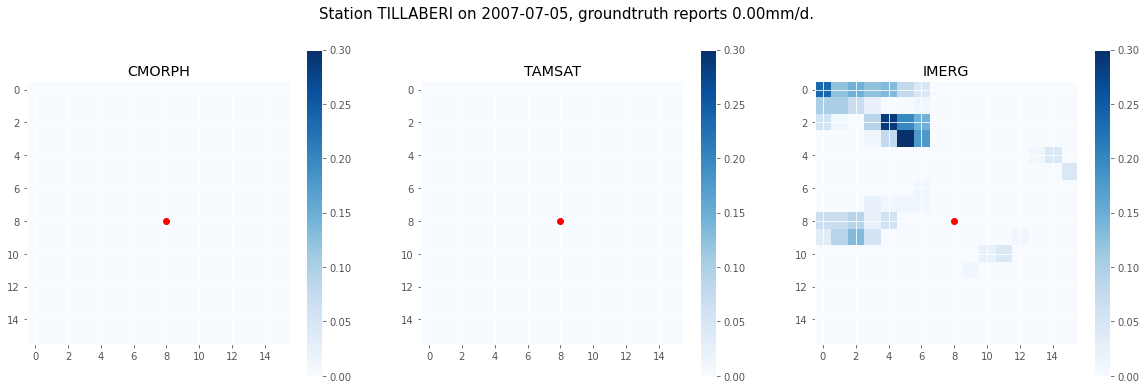

In [34]:
# select random image
ix = random.randint(0, x_cmorph.shape[0])
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ ix ] ][0]


# set minimum and maximum in colorbars
prec_max = max( np.max(x_cmorph[ix,:,:]) * m_CMORPH, np.max(x_tamsat[ix,:,:]) * m_TAMSAT, np.max(x_imerg[ix,:,:]) * m_IMERG )
prec_max = min(prec_max, 40)  # set a threshold so it can be visible
print(prec_max)


# create subplots
plt.figure(figsize=(20, 6))
# plt.suptitle(f'Station {station} on {df.index[ ind_tra[ix] ].date()}: LABEL={y_tra[ix]} | Rainfall {prec[ ind_tra[ ix ]]:.2f}mm/d.', fontsize=15)
plt.suptitle(f'Station {station} on {df.index[ ix ].date()}, groundtruth reports {prec[ ix ]:.2f}mm/d.', fontsize=15)
plt.subplot()

plt.subplot(131)
img = x_cmorph[ix, :, :] * m_CMORPH
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'CMORPH')  


plt.subplot(132)
img = x_tamsat[ix, :, :] * m_TAMSAT
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'TAMSAT')  


plt.subplot(133)
img = x_imerg[ix, :, :] * m_IMERG
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.title(f'IMERG')


plt.colorbar();

### Similarity indices:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( x_tra[ix, :, :, 0].flatten(), x_tra[ix, :, :, 1].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( x_tra[ix, :, :, 0].flatten(), x_tra[ix, :, :, 2].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( x_tra[ix, :, :, 1].flatten(), x_tra[ix, :, :, 2].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  -0.12.
Correlation between CMORPH and IMERG:   0.24.
Correlation between TAMSAT and IMERG:   0.03.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = ((x_tra[ix, :, :, 0] // div) ).astype(int)
TAMSAT_classes = ((x_tra[ix, :, :, 1] // div) ).astype(int)
IMERG_classes  = ((x_tra[ix, :, :, 2] // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1 2 3]
TAMSAT has the following classes:  [ 0  1  2  3  4  5  7  9 15 20 21 23 24 25 30 35 37 46 48 49]
IMERG  has the following classes:  [0 1 2 3 4 5 6 7 8]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (50, 50, 1, 4) and homogeneity: 0.95.
TAMSAT has shape of: (50, 50, 1, 4) and homogeneity: 0.85.
IMERG  has shape of: (50, 50, 1, 4) and homogeneity: 0.93.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (10000,).
TAMSAT has length of: (10000,).
IMERG  has length of: (10000,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.41.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.15.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.40.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = x_tra[ix, :, :, 0].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = x_tra[ix, :, :, 1].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  = x_tra[ix, :, :, 2].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.42.
CMORPH and IMERG  have a Hamming distance of: 0.19.
TAMSAT and IMERG  have a Hamming distance of: 0.39.


# Loss functions for imbalanced binary classification

We are going to test some more possible loss functions for this problem: focal-loss and weighted binary crossentropy. We import and define these loss functions here.

### 1. Focal-loss

In [ ]:
!pip install tensorflow_addons  # tensorflow_addons is not in collab by default

     |████████████████████████████████| 706kB 5.6MB/s 


In [ ]:
# import focal loss function

import tensorflow_addons as tfa
FocalLoss = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.2, gamma=2.0)  # (alpha=0.2, gamma=2.0) in paper


def focal_loss_custom(alpha, gamma):  # (alpha=0.2, gamma=2.0) in paper

   def binary_focal_loss(y_true, y_pred):

      FocalLoss = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
      y_true_K = tf.ones_like(y_true)  # tf.ones_like instead of K.ones_like
      focal_loss = FocalLoss(y_true, y_pred)
      return focal_loss
      
   return binary_focal_loss

### 2. Weighted binary crossentropy

In [ ]:
"""
Created on Thu Feb 28 15:09:26 2019
@author: lhuang
"""


def dyn_weighted_bincrossentropy(true, pred):
    """
    Calculates weighted binary cross entropy. The weights are determined dynamically
    by the balance of each category. This weight is calculated for each batch.
    
    The weights are calculted by determining the number of 'pos' and 'neg' classes 
    in the true labels, then dividing by the number of total predictions.
    
    For example if there is 1 pos class, and 99 neg class, then the weights are 1/100 and 99/100.
    These weights can be applied so false negatives are weighted 99/100, while false postives are weighted
    1/100. This prevents the classifier from labeling everything negative and getting 99% accuracy.
    
    This can be useful for unbalanced catagories.
    """
    # get the total number of inputs
    num_pred = keras.backend.sum(keras.backend.cast(pred < 0.5, true.dtype)) + keras.backend.sum(true)
    
    # get weight of values in 'pos' category
    zero_weight =  keras.backend.sum(true)/ num_pred +  keras.backend.epsilon() 
    
    # get weight of values in 'false' category
    one_weight = keras.backend.sum(keras.backend.cast(pred < 0.5, true.dtype)) / num_pred +  keras.backend.epsilon()

    # calculate the weight vector
    weights =  (1.0 - true) * zero_weight +  true * one_weight 
    
    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    
    # apply the weights
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)


def weighted_bincrossentropy(true, pred, weight_zero = 0.7086116, weight_one = 1.69839933):  # custom weights updated by the sklearn results 
    """
    Calculates weighted binary cross entropy. The weights are fixed.
        
    This can be useful for unbalanced catagories.
    
    Adjust the weights here depending on what is required.
    
    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives 
        will be penalize 10 times as much as false negatives.
    """
  
    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    
    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)

# Stacked-up 3 datasets

In [ ]:
# stacked_up_model = tf.keras.models.load_model(folder+'stacked_up_model')

In [35]:
per = sum(y_tra) * 100 / len(y_tra)
print(f'The percentage of rainy days in the TRAINING dataset is {per:.2f}%.')

per = sum(y_tst) * 100 / len(y_tst)
print(' ')
print(f'The percentage of rainy days in the TESTING dataset is {per:.2f}%.')

The percentage of rainy days in the TRAINING dataset is 28.35%.
 
The percentage of rainy days in the TESTING dataset is 28.02%.


In [36]:
# create model

i = Input(shape=x_tra[0].shape, name='Input')

x = Dense(128, activation='relu', name='Hidden1')(i)
x = Dropout(0.20, name='Dropout1')(x)

x = Dense(64,  activation='relu', name='Hidden2')(x)
x = Dropout(0.20, name='Dropout2')(x)

x = Dense(16,  activation='relu', name='Hidden3')(x)
x = Dropout(0.20, name='Dropout3')(x)

x = Dense(4,   activation='relu', name='Hidden4')(x)
x = Dropout(0.20, name='Dropout4')(x)

x = Dense(1, activation='sigmoid', name='Output')(x)

model = Model(i, x, name='Stacked_up_classifier')

# model summary
print('Model summary')
print("---" * 10)
print(model.summary())

Model summary
------------------------------
Model: "Stacked_up_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 3)]               0         
_________________________________________________________________
Hidden1 (Dense)              (None, 128)               512       
_________________________________________________________________
Dropout1 (Dropout)           (None, 128)               0         
_________________________________________________________________
Hidden2 (Dense)              (None, 64)                8256      
_________________________________________________________________
Dropout2 (Dropout)           (None, 64)                0         
_________________________________________________________________
Hidden3 (Dense)              (None, 16)                1040      
_________________________________________________________________


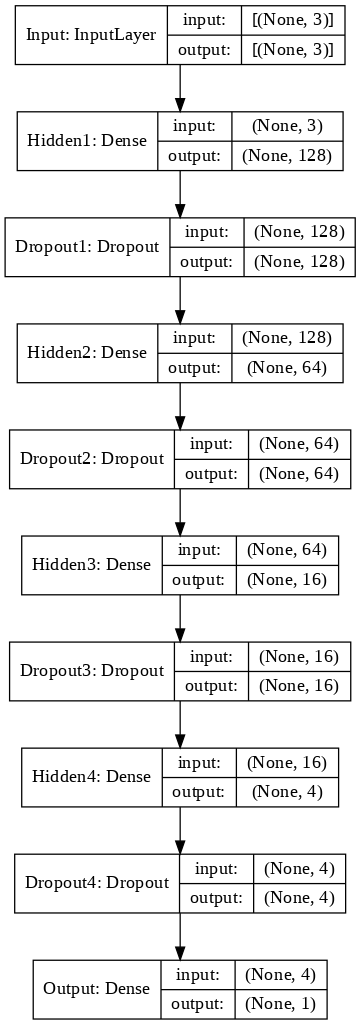

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=92)

In [ ]:
# Calculate the weights for each class so that we can balance the data
w = class_weight.compute_class_weight('balanced',
                                       np.unique(y_tra),
                                       y_tra
                                     )

weights = {0: w[0], 1: w[1]}

print('weights for 0 and 1:', w)

weights for 0 and 1: [0.6978104  1.76383648]


In [38]:
metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
          ]

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = model.fit(x_tra, y_tra, verbose = 1, epochs=400, batch_size=64)

Epoch 1/400
176/176 [==============================] - 1s 2ms/step - loss: 0.5159 - accuracy: 0.7124 - precision_1: 0.3766 - recall_1: 3.1339e-04
Epoch 2/400
176/176 [==============================] - 0s 2ms/step - loss: 0.5134 - accuracy: 0.7116 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 3/400
176/176 [==============================] - 0s 2ms/step - loss: 0.5243 - accuracy: 0.7128 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 4/400
176/176 [==============================] - 0s 2ms/step - loss: 0.5123 - accuracy: 0.7217 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 5/400
176/176 [==============================] - 0s 2ms/step - loss: 0.5115 - accuracy: 0.7151 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 6/400
176/176 [==============================] - 0s 2ms/step - loss: 0.5110 - accuracy: 0.7162 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 7/400
176/176 [==============================] - 0s 2ms/step - loss: 0.5143 - accuracy: 0.7134 - p

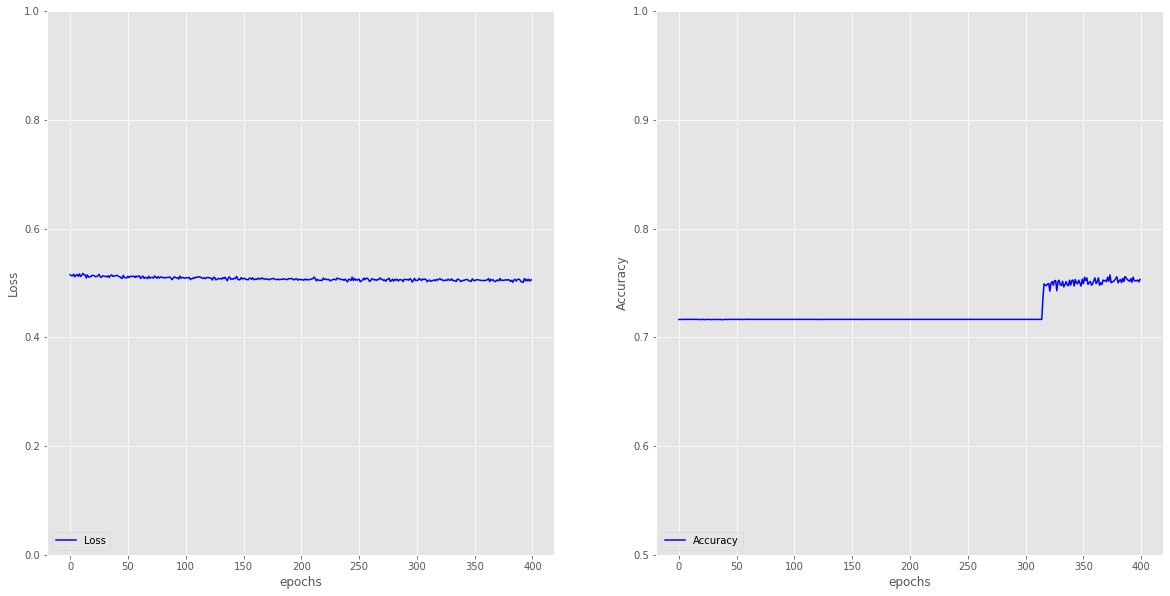

In [39]:
# plot results
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
# ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend(loc="lower left")
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
# ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend(loc="lower left")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0.5, 1.0);

Choose the modeled values wet/dry threshold:

In [40]:
thr_mod = 0.5  # everything below 'No Rain', everything above 'Rain'

Results on test dataset:

In [41]:
# Evaluate the model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = model.evaluate(x_tst, y_tst, batch_size=64)

print(' ')
print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test AUC:", results[2])
print(' ')


# Compare the total rainy days in all the datasets combined

y_mod = model.predict(x_tst)>thr_mod
count = sum(y_mod)

print('Total rainy days:')
print('--' * 10)
print('The model predicted', count[0], 'rainy days.')
print('There were actually', sum(y), 'rainy days.')

Evaluate on test data
------------------------------
76/76 [==============================] - 0s 1ms/step - loss: 0.4826 - accuracy: 0.7631 - precision_1: 0.5897 - recall_1: 0.5078
 
Test loss: 0.4826258420944214
Test accuracy: 0.763103187084198
Test AUC: 0.5896551609039307
 
Total rainy days:
--------------------
The model predicted 1160 rainy days.
There were actually 4527.0 rainy days.



               precision    recall  f1-score   support

     No Rain       0.82      0.86      0.84      3461
        Rain       0.59      0.51      0.55      1347

    accuracy                           0.76      4808
   macro avg       0.70      0.69      0.69      4808
weighted avg       0.75      0.76      0.76      4808



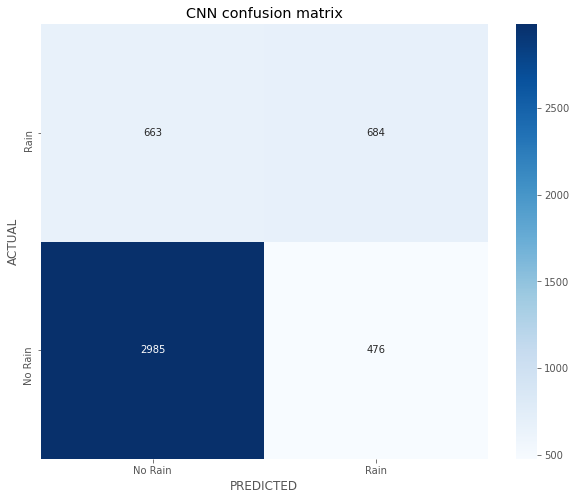

In [42]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

y_mod = model.predict(x_tst)>thr_mod

conf_matrix.append(confusion_matrix(y_tst, y_mod))
print('\n', classification_report(y_tst, y_mod, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('CNN confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

Let's see the missclassified images:

In [ ]:
# get index of misclassified images
y_mod = stacked_up_model.predict(x_tst)
miss_index = [i for i, y in enumerate(y_tst) if y != (y_mod[i][0] > thr_mod)]

In [ ]:
# visual inspection

print('Number of missclassified days:', len(miss_index), 'out of', len(y_tst))
print(' ')

for i in range(len(miss_index)):

  ix = miss_index[i]

  print(ix, y_tst[ix], y_mod[ix], y_mod[ix][0]>thr_mod)

Number of missclassified days: 1134 out of 4808
 
3 1.0 [0.37883568] False
5 1.0 [0.0782055] False
6 1.0 [0.25428635] False
7 1.0 [0.09276077] False
13 0.0 [0.559294] True
19 1.0 [0.09636492] False
21 1.0 [0.34180784] False
24 0.0 [0.55740935] True
27 1.0 [0.43589932] False
31 0.0 [0.5198042] True
35 1.0 [0.06957769] False
40 1.0 [0.25966787] False
60 0.0 [0.51523006] True
61 0.0 [0.53817457] True
63 1.0 [0.46076587] False
65 1.0 [0.20147267] False
69 1.0 [0.48058867] False
75 1.0 [0.49912837] False
77 1.0 [0.31344673] False
78 1.0 [0.12499273] False
82 1.0 [0.28843808] False
86 1.0 [0.37418473] False
87 1.0 [0.25327674] False
88 1.0 [0.17945173] False
92 1.0 [0.18553007] False
95 1.0 [0.4943899] False
105 1.0 [0.33425775] False
107 1.0 [0.24710456] False
108 1.0 [0.261903] False
110 0.0 [0.50963354] True
114 1.0 [0.3546865] False
116 0.0 [0.5341319] True
121 1.0 [0.31922495] False
122 1.0 [0.36606777] False
125 1.0 [0.43854254] False
127 1.0 [0.15366498] False
132 1.0 [0.36893916] Fal

### Boarderline fails
Number of produced outputs between 0.3 and 0.7

In [ ]:
per = np.sum((y_mod[ miss_index ] >= 0.3) & (y_mod[ miss_index ] <= 0.7)) / len(miss_index) * 100
print('The boarderline (between 0.3 and 0.7) missclassified days are', np.sum((y_mod[ miss_index ] >= 0.3) & (y_mod[ miss_index ] <= 0.7)), 'out of', len(miss_index), 'i.e.', per, '%.')

The boarderline (between 0.3 and 0.7) missclassified days are 678 out of 1134 i.e. 59.78835978835979 %.


### Missclassified images

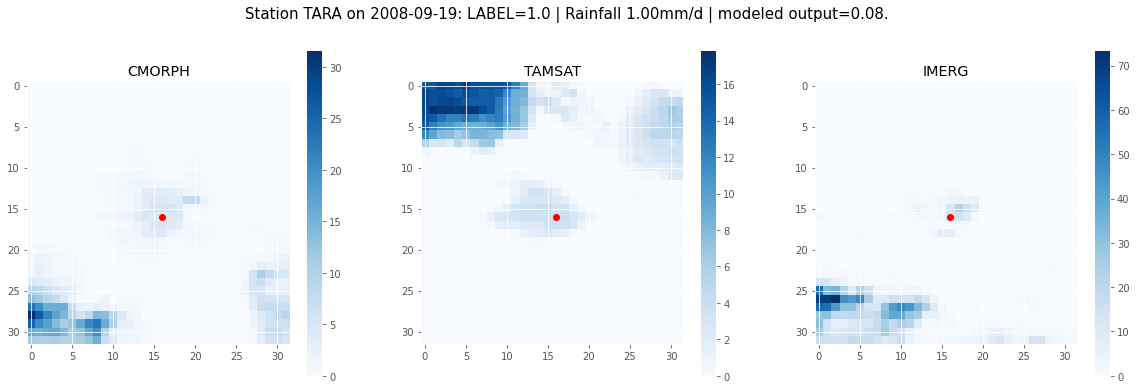

In [ ]:
# select random image
ix = miss_index[random.randint(0, len(miss_index))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]



# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | modeled output={y_mod[ix][0]:.2f}.', fontsize=15)
plt.subplot()

plt.subplot(131)
img = x_tst[ix, :, :, 0] * m_CMORPH
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'CMORPH')  


plt.subplot(132)
img = x_tst[ix, :, :, 1] * m_TAMSAT
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'TAMSAT')  


plt.subplot(133)
img = x_tst[ix, :, :, 2] * m_IMERG
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'IMERG');  

### Similarity indices of stacked-up model's misclassifications:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( x_tst[ix, :, :, 0].flatten(), x_tst[ix, :, :, 1].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( x_tst[ix, :, :, 0].flatten(), x_tst[ix, :, :, 2].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( x_tst[ix, :, :, 1].flatten(), x_tst[ix, :, :, 2].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  0.18.
Correlation between CMORPH and IMERG:   0.06.
Correlation between TAMSAT and IMERG:   0.32.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = ((x_tst[ix, :, :, 0] // div) ).astype(int)
TAMSAT_classes = ((x_tst[ix, :, :, 1] // div) ).astype(int)
IMERG_classes  = ((x_tst[ix, :, :, 2] // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1 2 3 4 5 6 7]
TAMSAT has the following classes:  [0 1]
IMERG  has the following classes:  [0]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (8, 8, 1, 4) and homogeneity: 0.96.
TAMSAT has shape of: (8, 8, 1, 4) and homogeneity: 0.98.
IMERG  has shape of: (8, 8, 1, 4) and homogeneity: 1.00.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (256,).
TAMSAT has length of: (256,).
IMERG  has length of: (256,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.17.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.24.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.14.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = x_tst[ix, :, :, 0].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = x_tst[ix, :, :, 1].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  = x_tst[ix, :, :, 2].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.22.
CMORPH and IMERG  have a Hamming distance of: 0.25.
TAMSAT and IMERG  have a Hamming distance of: 0.22.


Save model:

In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p saved_model
model.save(folder+'stacked_up_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Deep-Learning/stacked_up_model/assets


# Individual models

Save the training and test datasets

In [ ]:
input_CMORPH = x_tra[:, :, :, 0]
input_TAMSAT = x_tra[:, :, :, 1]
input_IMERG  = x_tra[:, :, :, 2]
output_training = y_tra

input_st_CMORPH = x_tst[:, :, :, 0]
input_st_TAMSAT = x_tst[:, :, :, 1]
input_st_IMERG  = x_tst[:, :, :, 2]
output_testing = y_tst

print('Shapes of datasets')
print(input_TAMSAT.shape, output_training.shape, input_st_IMERG.shape, output_testing.shape)

Shapes of datasets
(11218, 32, 32) (11218,) (4808, 32, 32) (4808,)


In [ ]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


## 1. CMORPH model

In [ ]:
# repeat to (32, 32, 3)

x_tra = np.zeros((len(x_tra), pixels, pixels, 3))
x_tst = np.zeros((len(x_tst), pixels, pixels, 3))

x_tra[:, :, :, 0] = input_CMORPH
x_tra[:, :, :, 1] = input_CMORPH
x_tra[:, :, :, 2] = input_CMORPH

x_tst[:, :, :, 0] = input_st_CMORPH
x_tst[:, :, :, 1] = input_st_CMORPH
x_tst[:, :, :, 2] = input_st_CMORPH

print(x_tra.shape)

(11218, 32, 32, 3)


In [ ]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


In [ ]:
x_tra[1111, 12, 12]

array([0.00079802, 0.00079802, 0.00079802])

In [ ]:
# CMORPH_model = tf.keras.models.load_model(folder+'UpdatedResolutions_CMORPH_model')

In [ ]:
per = sum(y_tra) * 100 / len(y_tra)
print(f'The percentage of rainy days in the TRAINING dataset is {per:.2f}%.')

per = sum(y_tst) * 100 / len(y_tst)
print(' ')
print(f'The percentage of rainy days in the TESTING dataset is {per:.2f}%.')

The percentage of rainy days in the TRAINING dataset is 25.81%.
 
The percentage of rainy days in the TESTING dataset is 26.63%.


In [ ]:
# create CMORPH_model

i = Input(shape=x_tra[0].shape, name='Input')

x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A1')(i)
x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A2')(x)
# x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A3')(x)
x = MaxPool2D(name='MaxPool2D_A')(x)  # Max pooling performs better than Average pooling

x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B1')(x)
x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B2')(x)
# x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B3')(x)
x = MaxPool2D(name='MaxPool2D_B')(x)

x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C1')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C2')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C3')(x)
x = MaxPool2D(name='MaxPool2D_C')(x)

x = Flatten(name='Flatten')(x)  # Flatten or Globalpooling

# x = GlobalAveragePooling2D(name='GlobalPooling')(x)

x = Dropout(0.10, name='Dropout_1')(x)
x = Dense(16, activation='tanh', name='Hidden')(x)

x = Dropout(0.10, name='Dropout_2')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

CMORPH_model = Model(i, x, name='CMORPH_model')

# model summary
print('Model summary')
print("---" * 10)
print(CMORPH_model.summary())

Model summary
------------------------------
Model: "CMORPH_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Convolutional_A1 (Conv2D)    (None, 32, 32, 8)         224       
_________________________________________________________________
Convolutional_A2 (Conv2D)    (None, 32, 32, 8)         584       
_________________________________________________________________
MaxPool2D_A (MaxPooling2D)   (None, 16, 16, 8)         0         
_________________________________________________________________
Convolutional_B1 (Conv2D)    (None, 16, 16, 16)        1168      
_________________________________________________________________
Convolutional_B2 (Conv2D)    (None, 16, 16, 16)        2320      
_________________________________________________________________
MaxPool2D

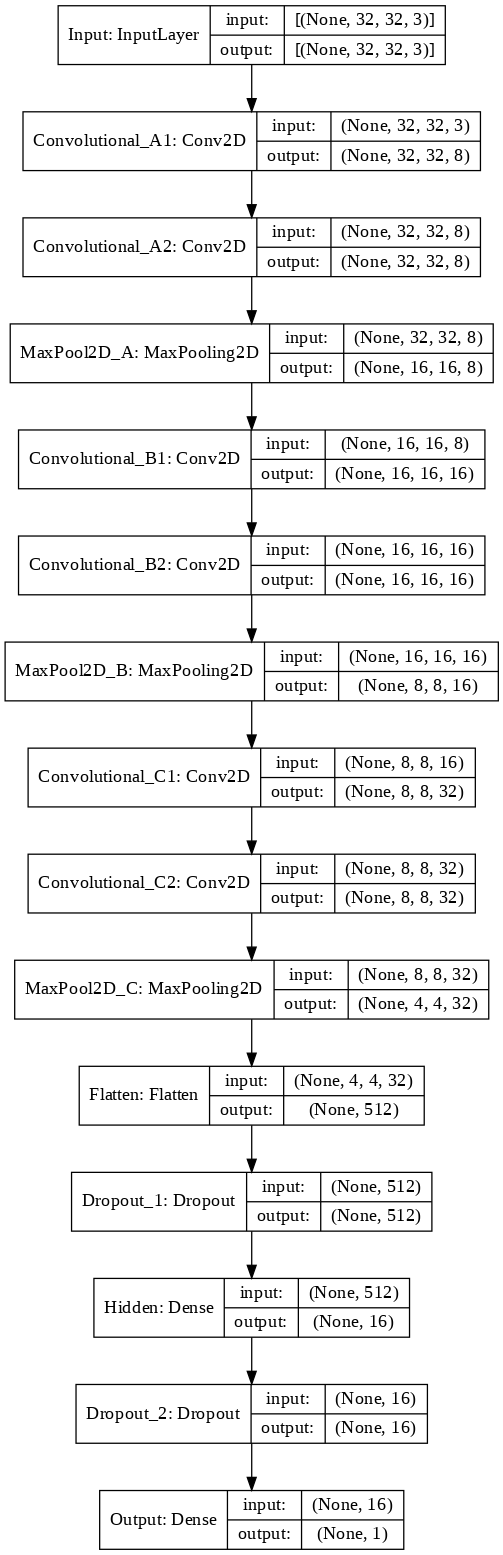

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(CMORPH_model, show_shapes=True, dpi=92)

In [ ]:
# Calculate the weights for each class so that we can balance the data
w = class_weight.compute_class_weight('balanced',
                                       np.unique(y_tra),
                                       y_tra
                                     )

weights = {0: w[0], 1: w[1]}

print('weights for 0 and 1:', w)

weights for 0 and 1: [0.67391304 1.9375    ]


In [ ]:
metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
          ]

# compile the model
CMORPH_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = CMORPH_model.fit(x_tra, y_tra, verbose = 1, epochs=20, batch_size=64)

Epoch 1/20
70/70 [==============================] - 8s 99ms/step - loss: 0.5136 - accuracy: 0.7463 - precision_1: 0.6288 - recall_1: 0.0425
Epoch 2/20
70/70 [==============================] - 7s 99ms/step - loss: 0.5085 - accuracy: 0.7467 - precision_1: 0.6319 - recall_1: 0.0626
Epoch 3/20
70/70 [==============================] - 7s 97ms/step - loss: 0.5017 - accuracy: 0.7595 - precision_1: 0.6744 - recall_1: 0.0987
Epoch 4/20
70/70 [==============================] - 7s 98ms/step - loss: 0.5016 - accuracy: 0.7525 - precision_1: 0.6735 - recall_1: 0.1236
Epoch 5/20
70/70 [==============================] - 7s 98ms/step - loss: 0.4990 - accuracy: 0.7553 - precision_1: 0.6372 - recall_1: 0.1368
Epoch 6/20
70/70 [==============================] - 7s 99ms/step - loss: 0.5018 - accuracy: 0.7503 - precision_1: 0.6448 - recall_1: 0.1597
Epoch 7/20
70/70 [==============================] - 7s 100ms/step - loss: 0.4906 - accuracy: 0.7631 - precision_1: 0.6360 - recall_1: 0.1580
Epoch 8/20
70/70 [=

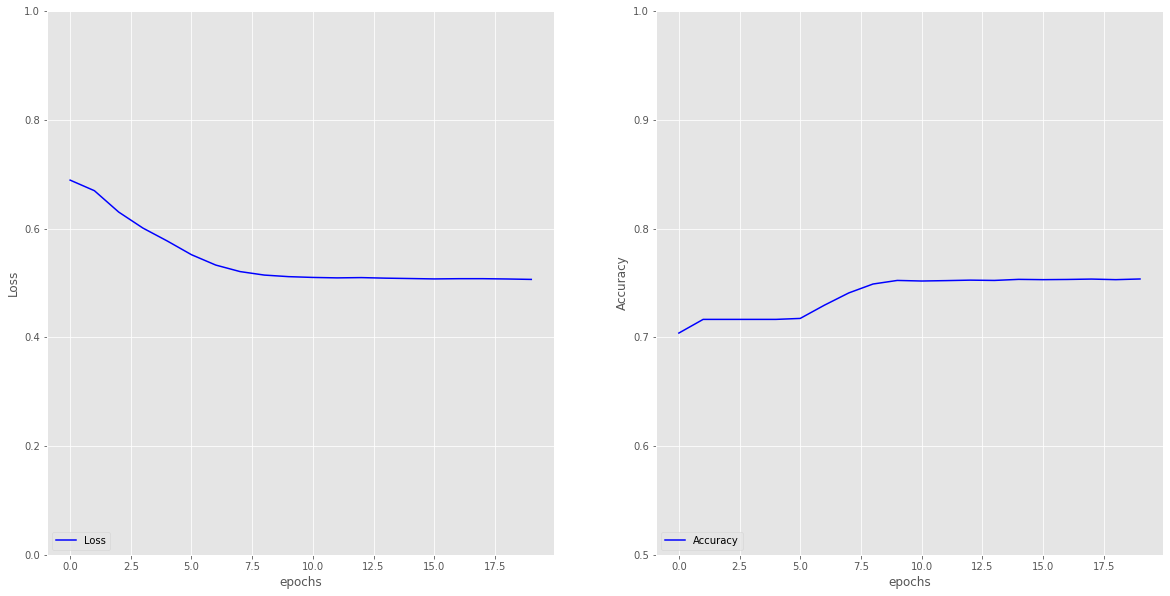

In [ ]:
# plot results
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
# ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend(loc="lower left")
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
# ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend(loc="lower left")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0.5, 1.0);

Choose the modeled values wet/dry threshold:

In [ ]:
thr_mod = 0.5  # everything below 'No Rain', everything above 'Rain'

Results on test dataset:

In [ ]:
# Evaluate the CMORPH_model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = CMORPH_model.evaluate(x_tst, y_tst, batch_size=64)

print(' ')
print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test AUC:", results[2])
print(' ')


# Compare the total rainy days in all the datasets combined

y_mod_CMORPH = CMORPH_model.predict(x_tst)>thr_mod
count = sum(y_mod_CMORPH)

print('Total rainy days:')
print('--' * 10)
print('The model predicted', count[0], 'rainy days.')
print('There were actually', sum(y), 'rainy days.')

Evaluate on test data
------------------------------
76/76 [==============================] - 3s 29ms/step - loss: 0.5000 - accuracy: 0.7552 - precision_5: 0.5982 - recall_5: 0.3846
 
Test loss: 0.49998506903648376
Test accuracy: 0.755199670791626
Test AUC: 0.5981523990631104
 
Total rainy days:
--------------------
The model predicted 866 rainy days.
There were actually 4527.0 rainy days.



               precision    recall  f1-score   support

     No Rain       0.79      0.90      0.84      3461
        Rain       0.60      0.38      0.47      1347

    accuracy                           0.76      4808
   macro avg       0.69      0.64      0.65      4808
weighted avg       0.74      0.76      0.74      4808



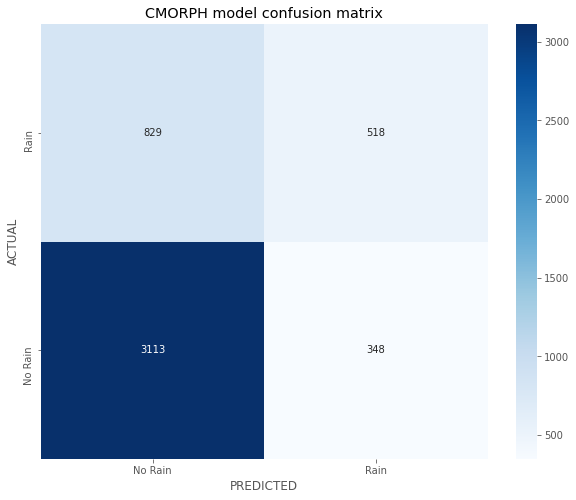

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

y_mod_CMORPH = CMORPH_model.predict(x_tst)>thr_mod

conf_matrix.append(confusion_matrix(y_tst, y_mod_CMORPH))
print('\n', classification_report(y_tst, y_mod_CMORPH, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('CMORPH model confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

Let's see the missclassified images:

In [ ]:
# get index of misclassified images
y_mod_CMORPH = CMORPH_model.predict(x_tst)
miss_index_CMORPH = [i for i, y in enumerate(y_tst) if y != (y_mod_CMORPH[i][0] > thr_mod)]

In [ ]:
# visual inspection

# print('Number of missclassified days:', len(miss_index_CMORPH), 'out of', len(y_tst))
# print(' ')

# for i in range(len(miss_index_CMORPH)):

#   ix = miss_index_CMORPH[i]

#   print(ix, y_tst[ix], y_mod_CMORPH[ix], y_mod_CMORPH[ix][0]>thr_mod)

### Boarderline fails
Number of produced outputs between 0.3 and 0.7

In [ ]:
per = np.sum((y_mod_CMORPH[ miss_index_CMORPH ] >= 0.3) & (y_mod_CMORPH[ miss_index_CMORPH ] <= 0.7)) / len(miss_index_CMORPH) * 100
print('The boarderline (between 0.3 and 0.7) missclassified days are', np.sum((y_mod_CMORPH[ miss_index_CMORPH ] >= 0.3) & (y_mod_CMORPH[ miss_index_CMORPH ] <= 0.7)), 'out of', len(miss_index_CMORPH), 'i.e.', per, '%.')

The boarderline (between 0.3 and 0.7) missclassified days are 728 out of 1177 i.e. 61.85216652506372 %.


### Missclassified images

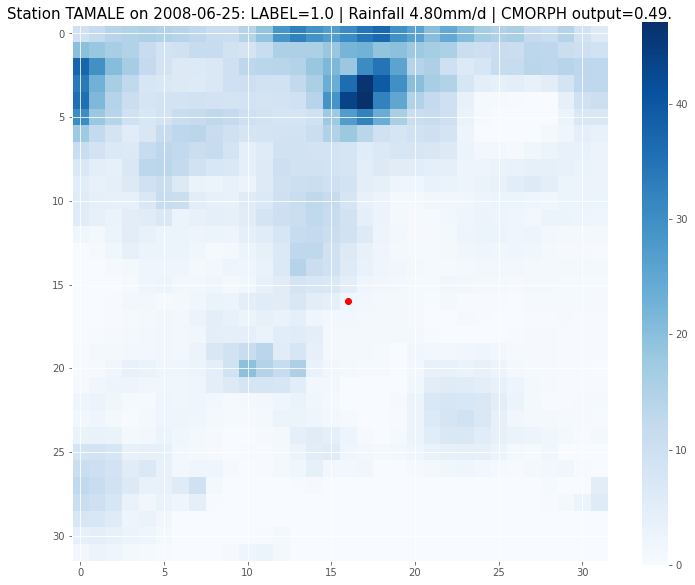

In [ ]:
# select random image
ix = miss_index_CMORPH[random.randint(0, len(miss_index_CMORPH))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]

# create subplots
plt.figure(figsize=(12, 10))
plt.title(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | CMORPH output={y_mod_CMORPH[ix][0]:.2f}.', fontsize=15)

img = x_tst[ix, :, :, 0] * m_CMORPH
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar();

Save model:

In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p UpdatedResolutions_saved_model
CMORPH_model.save(folder+'UpdatedResolutions_CMORPH_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Deep-Learning/UpdatedResolutions_CMORPH_model/assets


## 2. TAMSAT model

In [ ]:
# repeat to (32, 32, 3)

x_tra = np.zeros((len(x_tra), pixels, pixels, 3))
x_tst = np.zeros((len(x_tst), pixels, pixels, 3))

x_tra[:, :, :, 0] = input_TAMSAT
x_tra[:, :, :, 1] = input_TAMSAT
x_tra[:, :, :, 2] = input_TAMSAT

x_tst[:, :, :, 0] = input_st_TAMSAT
x_tst[:, :, :, 1] = input_st_TAMSAT
x_tst[:, :, :, 2] = input_st_TAMSAT

print(x_tra.shape)

(11218, 32, 32, 3)


In [ ]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


In [ ]:
x_tra[1111, 12, 12, 0]

0.036916677499025094

In [ ]:
# TAMSAT_model = tf.keras.models.load_model(folder+'UpdatedResolutions_TAMSAT_model')

In [ ]:
per = sum(y_tra) * 100 / len(y_tra)
print(f'The percentage of rainy days in the TRAINING dataset is {per:.2f}%.')

per = sum(y_tst) * 100 / len(y_tst)
print(' ')
print(f'The percentage of rainy days in the TESTING dataset is {per:.2f}%.')

The percentage of rainy days in the TRAINING dataset is 28.35%.
 
The percentage of rainy days in the TESTING dataset is 28.02%.


In [ ]:
# create TAMSAT_model

i = Input(shape=x_tra[0].shape, name='Input')

x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A1')(i)
x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A2')(x)
# x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A3')(x)
x = MaxPool2D(name='MaxPool2D_A')(x)  # Max pooling performs better than Average pooling

x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B1')(x)
x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B2')(x)
# x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B3')(x)
x = MaxPool2D(name='MaxPool2D_B')(x)

x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C1')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C2')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C3')(x)
x = MaxPool2D(name='MaxPool2D_C')(x)

x = Flatten(name='Flatten')(x)  # Flatten or Globalpooling

# x = GlobalAveragePooling2D(name='GlobalPooling')(x)

x = Dropout(0.10, name='Dropout_1')(x)
x = Dense(16, activation='tanh', name='Hidden')(x)

x = Dropout(0.10, name='Dropout_2')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

TAMSAT_model = Model(i, x, name='TAMSAT_model')

# model summary
print('Model summary')
print("---" * 10)
print(TAMSAT_model.summary())

Model summary
------------------------------
Model: "TAMSAT_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Convolutional_A1 (Conv2D)    (None, 32, 32, 8)         224       
_________________________________________________________________
Convolutional_A2 (Conv2D)    (None, 32, 32, 8)         584       
_________________________________________________________________
MaxPool2D_A (MaxPooling2D)   (None, 16, 16, 8)         0         
_________________________________________________________________
Convolutional_B1 (Conv2D)    (None, 16, 16, 16)        1168      
_________________________________________________________________
Convolutional_B2 (Conv2D)    (None, 16, 16, 16)        2320      
_________________________________________________________________
MaxPool2D

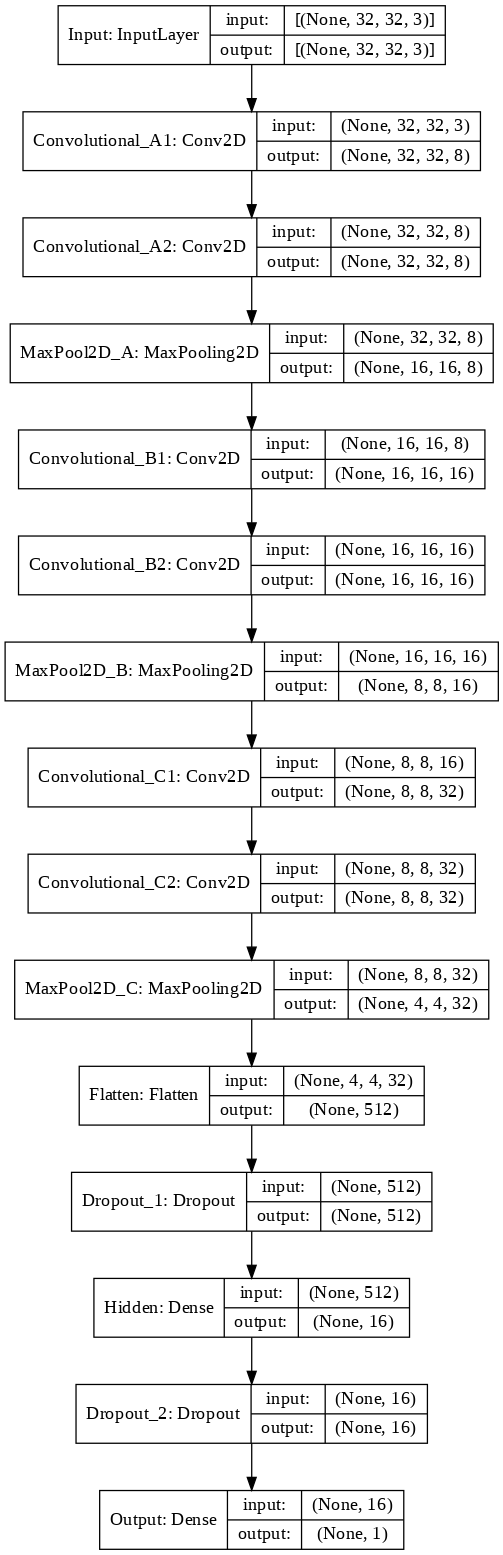

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(TAMSAT_model, show_shapes=True, dpi=92)

In [ ]:
# Calculate the weights for each class so that we can balance the data
w = class_weight.compute_class_weight('balanced',
                                       np.unique(y_tra),
                                       y_tra
                                     )

weights = {0: w[0], 1: w[1]}

print('weights for 0 and 1:', w)

weights for 0 and 1: [0.6978104  1.76383648]


In [ ]:
metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
          ]

# compile the model
TAMSAT_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = TAMSAT_model.fit(x_tra, y_tra, verbose = 1, epochs=30, batch_size=64)

Epoch 1/30
176/176 [==============================] - 18s 95ms/step - loss: 0.6871 - accuracy: 0.7065 - precision: 0.3554 - recall: 0.0190
Epoch 2/30
176/176 [==============================] - 17s 95ms/step - loss: 0.6744 - accuracy: 0.7091 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/30
176/176 [==============================] - 17s 94ms/step - loss: 0.6505 - accuracy: 0.7261 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/30
176/176 [==============================] - 17s 95ms/step - loss: 0.6380 - accuracy: 0.7160 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/30
176/176 [==============================] - 17s 94ms/step - loss: 0.6194 - accuracy: 0.7146 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/30
176/176 [==============================] - 17s 95ms/step - loss: 0.5939 - accuracy: 0.7162 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/30
176/176 [==============================] - 17s 94ms/step - loss: 0.5633 - accuracy: 0.7194 - precision: 0.0000e+00 

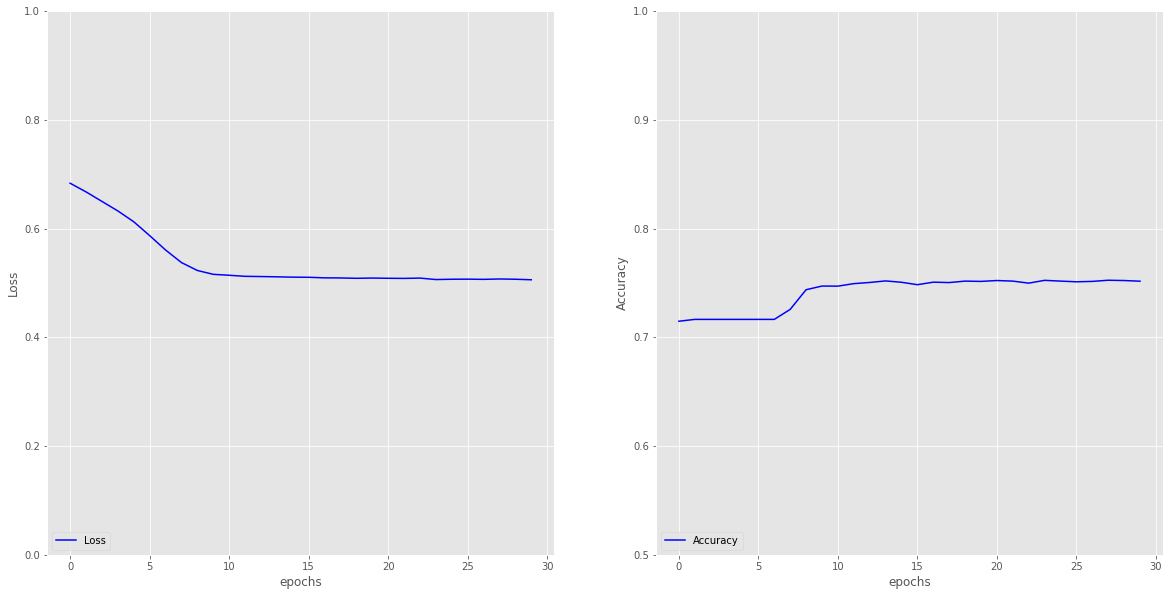

In [ ]:
# plot results
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
# ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend(loc="lower left")
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
# ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend(loc="lower left")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0.5, 1.0);

Choose the modeled values wet/dry threshold:

In [ ]:
thr_mod = 0.5  # everything below 'No Rain', everything above 'Rain'

Results on test dataset:

In [ ]:
# Evaluate the TAMSAT_model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = TAMSAT_model.evaluate(x_tst, y_tst, batch_size=64)

print(' ')
print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test AUC:", results[2])
print(' ')


# Compare the total rainy days in all the datasets combined

y_mod_TAMSAT = TAMSAT_model.predict(x_tst)>thr_mod
count = sum(y_mod_TAMSAT)

print('Total rainy days:')
print('--' * 10)
print('The model predicted', count[0], 'rainy days.')
print('There were actually', sum(y), 'rainy days.')

Evaluate on test data
------------------------------
76/76 [==============================] - 3s 30ms/step - loss: 0.4980 - accuracy: 0.7583 - precision: 0.6029 - recall: 0.4024
 
Test loss: 0.49802467226982117
Test accuracy: 0.7583194971084595
Test AUC: 0.6028921008110046
 
Total rainy days:
--------------------
The model predicted 899 rainy days.
There were actually 4527.0 rainy days.



               precision    recall  f1-score   support

     No Rain       0.80      0.89      0.84      3461
        Rain       0.60      0.42      0.50      1347

    accuracy                           0.76      4808
   macro avg       0.70      0.66      0.67      4808
weighted avg       0.74      0.76      0.75      4808



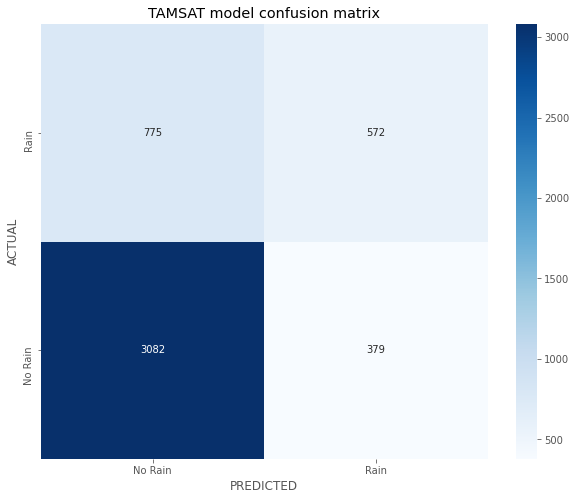

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

y_mod_TAMSAT = TAMSAT_model.predict(x_tst)>thr_mod

conf_matrix.append(confusion_matrix(y_tst, y_mod_TAMSAT))
print('\n', classification_report(y_tst, y_mod_TAMSAT, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('TAMSAT model confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

Let's see the missclassified images:

In [ ]:
# get index of misclassified images
y_mod_TAMSAT = TAMSAT_model.predict(x_tst)
miss_index_TAMSAT = [i for i, y in enumerate(y_tst) if y != (y_mod_TAMSAT[i][0] > thr_mod)]

In [ ]:
# # visual inspection

# print('Number of missclassified days:', len(miss_index_TAMSAT), 'out of', len(y_tst))
# print(' ')

# for i in range(len(miss_index_TAMSAT)):

#   ix = miss_index_TAMSAT[i]

#   print(ix, y_tst[ix], y_mod_TAMSAT[ix], y_mod_TAMSAT[ix][0]>thr_mod)

### Boarderline fails
Number of produced outputs between 0.3 and 0.7

In [ ]:
per = np.sum((y_mod_TAMSAT[ miss_index_TAMSAT ] >= 0.3) & (y_mod_TAMSAT[ miss_index_TAMSAT ] <= 0.7)) / len(miss_index_TAMSAT) * 100
print('The boarderline (between 0.3 and 0.7) missclassified days are', np.sum((y_mod_TAMSAT[ miss_index_TAMSAT ] >= 0.3) & (y_mod_TAMSAT[ miss_index_TAMSAT ] <= 0.7)), 'out of', len(miss_index_TAMSAT), 'i.e.', per, '%.')

The boarderline (between 0.3 and 0.7) missclassified days are 737 out of 1162 i.e. 63.42512908777969 %.


### Missclassified images

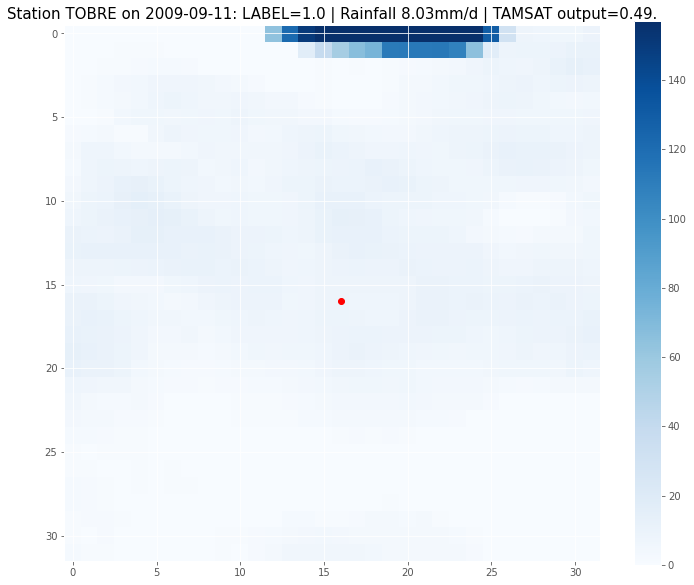

In [ ]:
# select random image
ix = miss_index_TAMSAT[random.randint(0, len(miss_index_TAMSAT))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]



# create subplots
plt.figure(figsize=(12, 10))
plt.title(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | TAMSAT output={y_mod_TAMSAT[ix][0]:.2f}.', fontsize=15)


img = x_tst[ix, :, :, 0] * m_TAMSAT

# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar();

Save model:

In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p UpdatedResolutions_saved_model
TAMSAT_model.save(folder+'UpdatedResolutions_TAMSAT_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Deep-Learning/UpdatedResolutions_TAMSAT_model/assets


## 3. IMERG model

In [ ]:
# repeat to (32, 32, 3)

x_tra = np.zeros((len(x_tra), pixels, pixels, 3))
x_tst = np.zeros((len(x_tst), pixels, pixels, 3))

x_tra[:, :, :, 0] = input_IMERG
x_tra[:, :, :, 1] = input_IMERG
x_tra[:, :, :, 2] = input_IMERG

x_tst[:, :, :, 0] = input_st_IMERG
x_tst[:, :, :, 1] = input_st_IMERG
x_tst[:, :, :, 2] = input_st_IMERG

print(x_tra.shape)

(11218, 32, 32, 3)


In [ ]:
x_tra[1111, 12, 12, 0]

0.0

In [ ]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


In [ ]:
# IMERG_model = tf.keras.models.load_model(folder+'UpdatedResolutions_IMERG_model')

In [ ]:
per = sum(y_tra) * 100 / len(y_tra)
print(f'The percentage of rainy days in the TRAINING dataset is {per:.2f}%.')

per = sum(y_tst) * 100 / len(y_tst)
print(' ')
print(f'The percentage of rainy days in the TESTING dataset is {per:.2f}%.')

The percentage of rainy days in the TRAINING dataset is 28.35%.
 
The percentage of rainy days in the TESTING dataset is 28.02%.


In [ ]:
# create IMERG_model

i = Input(shape=x_tra[0].shape, name='Input')

x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='valid', name='Convolutional_A1')(i)
x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='valid', name='Convolutional_A2')(x)
# x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A3')(x)
x = MaxPool2D(name='MaxPool2D_A')(x)  # Max pooling performs better than Average pooling

x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='valid', name='Convolutional_B1')(x)
x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='valid', name='Convolutional_B2')(x)
# x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B3')(x)
x = MaxPool2D(name='MaxPool2D_B')(x)

# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C1')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C2')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C3')(x)
# x = MaxPool2D(name='MaxPool2D_C')(x)

x = Flatten(name='Flatten')(x)  # Flatten or Globalpooling

# x = GlobalAveragePooling2D(name='GlobalPooling')(x)

x = Dropout(0.20, name='Dropout_1')(x)
x = Dense(16, activation='relu', name='Hidden')(x)

x = Dropout(0.20, name='Dropout_2')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

IMERG_model = Model(i, x, name='IMERG_model')

# model summary
print('Model summary')
print("---" * 10)
print(IMERG_model.summary())

Model summary
------------------------------
Model: "IMERG_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Convolutional_A1 (Conv2D)    (None, 30, 30, 8)         224       
_________________________________________________________________
Convolutional_A2 (Conv2D)    (None, 28, 28, 8)         584       
_________________________________________________________________
MaxPool2D_A (MaxPooling2D)   (None, 14, 14, 8)         0         
_________________________________________________________________
Convolutional_B1 (Conv2D)    (None, 12, 12, 16)        1168      
_________________________________________________________________
Convolutional_B2 (Conv2D)    (None, 10, 10, 16)        2320      
_________________________________________________________________
MaxPool2D_

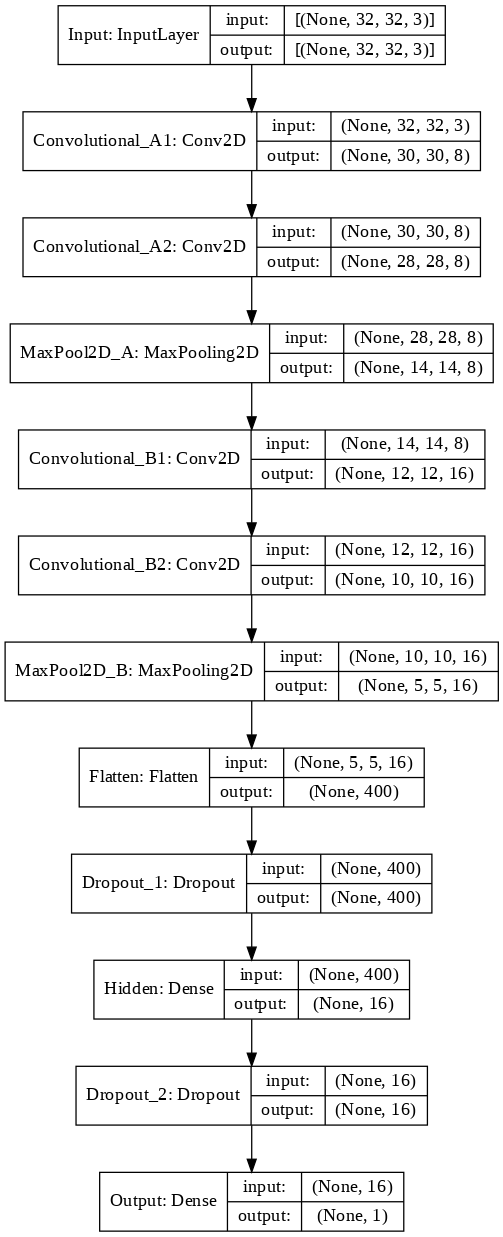

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(IMERG_model, show_shapes=True, dpi=92)

In [ ]:
# Calculate the weights for each class so that we can balance the data
w = class_weight.compute_class_weight('balanced',
                                       np.unique(y_tra),
                                       y_tra
                                     )

weights = {0: w[0], 1: w[1]}

print('weights for 0 and 1:', w)

weights for 0 and 1: [0.6978104  1.76383648]


In [ ]:
metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
          ]

# compile the model
IMERG_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = IMERG_model.fit(x_tra, y_tra, verbose = 1, epochs=30, batch_size=64)

Epoch 1/30
176/176 [==============================] - 12s 60ms/step - loss: 0.6937 - accuracy: 0.3951 - precision_1: 0.3166 - recall_1: 0.9101
Epoch 2/30
176/176 [==============================] - 10s 59ms/step - loss: 0.6927 - accuracy: 0.6473 - precision_1: 0.4073 - recall_1: 0.5821
Epoch 3/30
176/176 [==============================] - 11s 60ms/step - loss: 0.6918 - accuracy: 0.7161 - precision_1: 0.5032 - recall_1: 0.3708
Epoch 4/30
176/176 [==============================] - 11s 60ms/step - loss: 0.6907 - accuracy: 0.7335 - precision_1: 0.5686 - recall_1: 0.2323
Epoch 5/30
176/176 [==============================] - 10s 59ms/step - loss: 0.6895 - accuracy: 0.7254 - precision_1: 0.5905 - recall_1: 0.1377
Epoch 6/30
176/176 [==============================] - 11s 61ms/step - loss: 0.6875 - accuracy: 0.7289 - precision_1: 0.6390 - recall_1: 0.0906
Epoch 7/30
176/176 [==============================] - 10s 59ms/step - loss: 0.6840 - accuracy: 0.7266 - precision_1: 0.6820 - recall_1: 0.0360

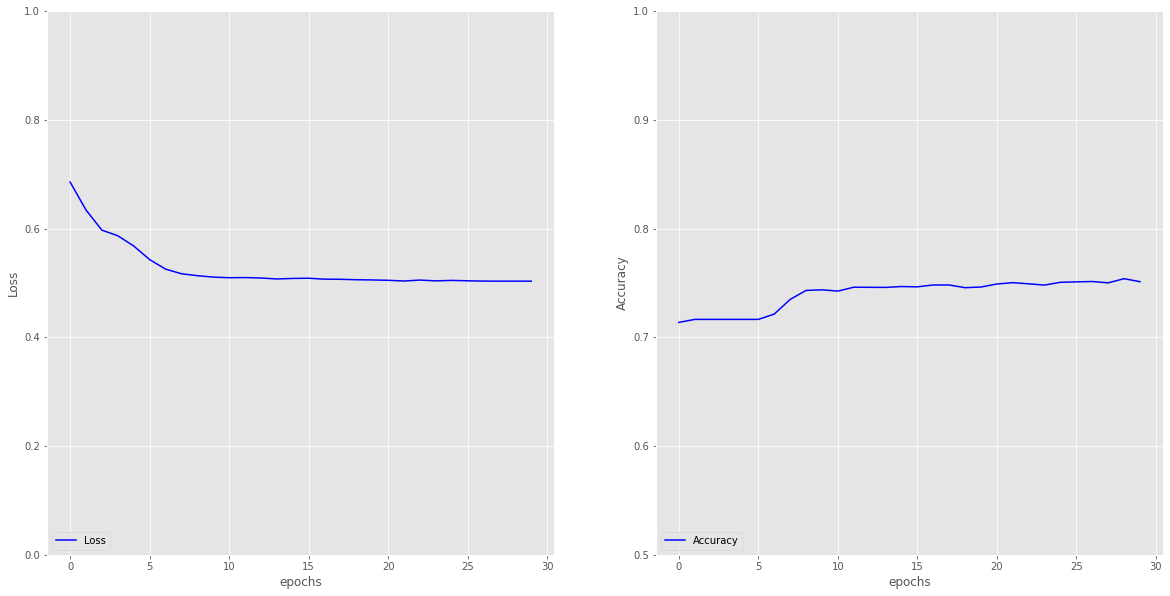

In [ ]:
# plot results
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
# ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend(loc="lower left")
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
# ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend(loc="lower left")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0.5, 1.0);

Choose the modeled values wet/dry threshold:

In [ ]:
thr_mod = 0.5  # everything below 'No Rain', everything above 'Rain'

Results on test dataset:

In [ ]:
# Evaluate the IMERG_model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = IMERG_model.evaluate(x_tst, y_tst, batch_size=64)

print(' ')
print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test AUC:", results[2])
print(' ')


# Compare the total rainy days in all the datasets combined

y_mod_IMERG = IMERG_model.predict(x_tst)>thr_mod
count = sum(y_mod_IMERG)

print('Total rainy days:')
print('--' * 10)
print('The model predicted', count[0], 'rainy days.')
print('There were actually', sum(y), 'rainy days.')

Evaluate on test data
------------------------------
76/76 [==============================] - 2s 18ms/step - loss: 0.4988 - accuracy: 0.7671 - precision_1: 0.6587 - recall_1: 0.3497
 
Test loss: 0.49876725673675537
Test accuracy: 0.7670549154281616
Test AUC: 0.6587412357330322
 
Total rainy days:
--------------------
The model predicted 715 rainy days.
There were actually 4527.0 rainy days.



               precision    recall  f1-score   support

     No Rain       0.79      0.93      0.85      3461
        Rain       0.66      0.35      0.46      1347

    accuracy                           0.77      4808
   macro avg       0.72      0.64      0.65      4808
weighted avg       0.75      0.77      0.74      4808



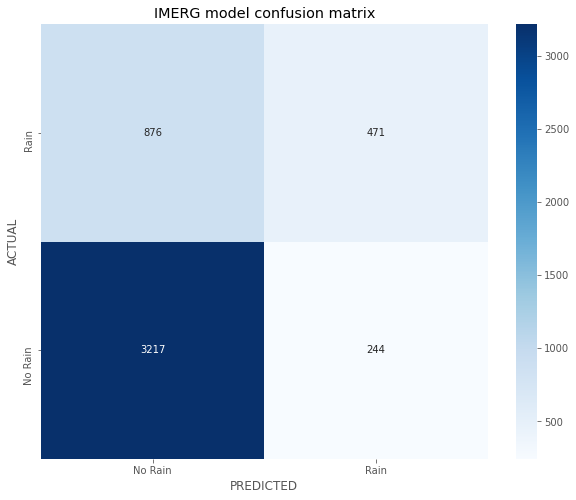

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

y_mod_IMERG = IMERG_model.predict(x_tst)>thr_mod

conf_matrix.append(confusion_matrix(y_tst, y_mod_IMERG))
print('\n', classification_report(y_tst, y_mod_IMERG, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('IMERG model confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

Let's see the missclassified images:

In [ ]:
# get index of misclassified images
y_mod_IMERG = IMERG_model.predict(x_tst)
miss_index_IMERG = [i for i, y in enumerate(y_tst) if y != (y_mod_IMERG[i][0] > thr_mod)]

In [ ]:
# # visual inspection

# print('Number of missclassified days:', len(miss_index_IMERG), 'out of', len(y_tst))
# print(' ')

# for i in range(len(miss_index_IMERG)):

#   ix = miss_index_IMERG[i]

#   print(ix, y_tst[ix], y_mod_IMERG[ix], y_mod_IMERG[ix][0]>thr_mod)

### Boarderline fails
Number of produced outputs between 0.3 and 0.7

In [ ]:
per = np.sum((y_mod_IMERG[ miss_index_IMERG ] >= 0.3) & (y_mod_IMERG[ miss_index_IMERG ] <= 0.7)) / len(miss_index_IMERG) * 100
print('The boarderline (between 0.3 and 0.7) missclassified days are', np.sum((y_mod_IMERG[ miss_index_IMERG ] >= 0.3) & (y_mod_IMERG[ miss_index_IMERG ] <= 0.7)), 'out of', len(miss_index_IMERG), 'i.e.', per, '%.')

The boarderline (between 0.3 and 0.7) missclassified days are 525 out of 1120 i.e. 46.875 %.


### Missclassified images

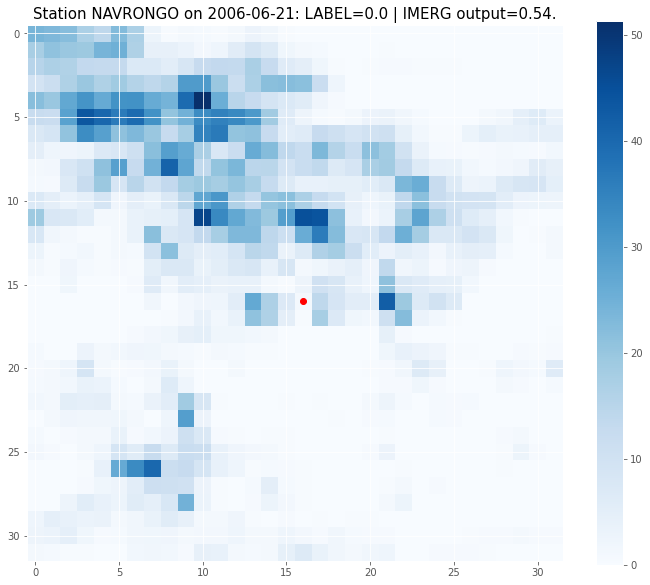

In [ ]:
# select random image
ix = miss_index_IMERG[random.randint(0, len(miss_index_IMERG))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]


# create subplots
plt.figure(figsize=(12, 10))
plt.title(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | IMERG output={y_mod_IMERG[ix][0]:.2f}.', fontsize=15)


img = x_tst[ix, :, :, 2] * m_IMERG

# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar();

Save model:

In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p UpdatedResolutions_saved_model
IMERG_model.save(folder+'UpdatedResolutions_IMERG_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Deep-Learning/UpdatedResolutions_IMERG_model/assets


# Majority vote

### Assess individual datasets

In [ ]:
idx = np.intersect1d(miss_index_CMORPH, miss_index_TAMSAT, miss_index_IMERG)


per = len(idx) * 100 / min(len(miss_index_CMORPH), len(miss_index_TAMSAT), len(miss_index_IMERG))
print(f'Percentage of common misclasifications in (smallest) misclasification index: {per:.2f}%.')
print(' ')

per = len(idx) * 100 / len(y_tst)
# print(len(idx), idx)  # common index of 2
print(f'Percentage of common misclasifications out of total test dataset: {per:.2f}%.')
print(' ')
per = 100 - per
print(f'Can we assume that the maximum possible accuracy is {per:.2f}% ?')

Percentage of common misclasifications in (smallest) misclasification index: 89.02%.
 
Percentage of common misclasifications out of total test dataset: 20.74%.
 
Can we assume that the maximum possible accuracy is 79.26% ?


## Majority vote Alternative No.1

Assessing binary output

In [ ]:
y_mod = (y_mod_CMORPH>0.5).astype(int) + (y_mod_TAMSAT>0.5).astype(int) + (y_mod_IMERG>0.5).astype(int)

# get index of misclassified images
miss_index = [i for i, y in enumerate(y_tst) if y != (y_mod[i][0]>1.5)]

# visual inspection

print('Number of missclassified days:', len(miss_index), 'out of', len(y_tst))
print(' ')

for i in range(len(miss_index)):

  ix = miss_index[i]

  print(ix, y_tst[ix], y_mod[ix], y_mod[ix][0]>1.5)

Number of missclassified days: 1150 out of 4808
 
3 1.0 [0] False
5 1.0 [0] False
6 1.0 [0] False
7 1.0 [0] False
19 1.0 [0] False
21 1.0 [1] False
24 0.0 [3] True
27 1.0 [0] False
31 0.0 [2] True
35 1.0 [0] False
40 1.0 [0] False
60 0.0 [2] True
61 0.0 [2] True
63 1.0 [1] False
65 1.0 [0] False
69 1.0 [1] False
75 1.0 [1] False
77 1.0 [0] False
78 1.0 [0] False
82 1.0 [0] False
86 1.0 [0] False
87 1.0 [0] False
88 1.0 [0] False
92 1.0 [0] False
105 1.0 [0] False
107 1.0 [0] False
108 1.0 [0] False
114 1.0 [0] False
121 1.0 [1] False
122 1.0 [1] False
125 1.0 [1] False
127 1.0 [0] False
132 1.0 [0] False
134 1.0 [0] False
136 0.0 [3] True
142 1.0 [0] False
146 1.0 [0] False
147 1.0 [0] False
155 1.0 [0] False
177 0.0 [2] True
186 1.0 [0] False
188 1.0 [0] False
189 0.0 [3] True
190 0.0 [2] True
191 1.0 [0] False
195 1.0 [1] False
198 0.0 [3] True
201 1.0 [1] False
207 1.0 [0] False
213 1.0 [0] False
215 1.0 [0] False
220 1.0 [0] False
222 1.0 [0] False
225 0.0 [3] True
226 1.0 [1] Fals

In [ ]:
per = np.sum((y_mod[ miss_index ] >= 0.9) & (y_mod[ miss_index ] <= 2.1)) / len(miss_index) * 100
print('The boarderline (between 0.9 and 2.1) missclassified days are', np.sum((y_mod[ miss_index ] >= 0.9) & (y_mod[ miss_index ] <= 2.1)), 'out of', len(miss_index), 'i.e.', per, '%.')

The boarderline (between 0.9 and 2.1) missclassified days are 359 out of 1150 i.e. 31.217391304347824 %.


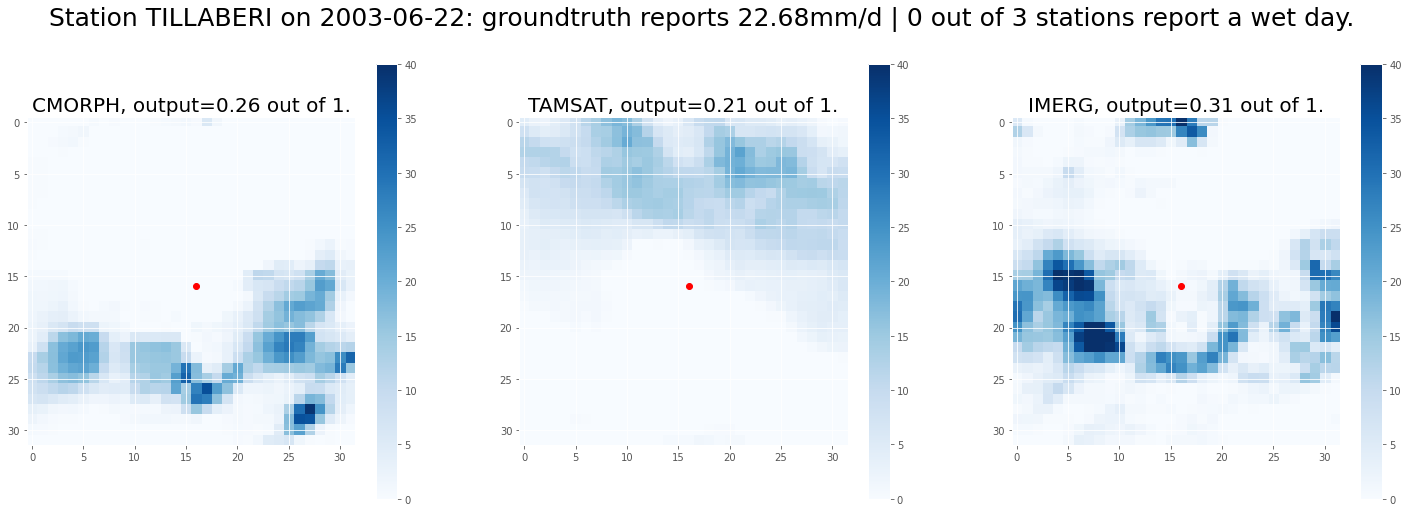

In [ ]:
# select random image
ix = miss_index[random.randint(0, len(miss_index))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]


# set minimum and maximum in colorbars
prec_max = max( np.max(input_st_CMORPH[ix,:,:]) * m_CMORPH, np.max(input_st_TAMSAT[ix,:,:]) * m_TAMSAT, np.max(input_st_IMERG[ix,:,:]) * m_IMERG )
prec_max = min(prec_max, 40)  # set a threshold so it can be visible
# print(prec_max)



# create subplots
plt.figure(figsize=(25, 8))
# plt.suptitle(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | output={y_mod[ix][0]:.2f} out of 3.', fontsize=15)
plt.suptitle(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: groundtruth reports {prec[ ind_tst[ ix ]]:.2f}mm/d | {y_mod[ix][0]:.0f} out of 3 stations report a wet day.', fontsize=25 )
plt.subplot()

plt.subplot(131)
img = input_st_CMORPH[ix, :, :] * m_CMORPH
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'CMORPH, output={y_mod_CMORPH[ix][0]:.2f} out of 1.', fontsize=20)  


plt.subplot(132)
img = input_st_TAMSAT[ix, :, :] * m_TAMSAT
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'TAMSAT, output={y_mod_TAMSAT[ix][0]:.2f} out of 1.', fontsize=20)   


plt.subplot(133)
img = input_st_IMERG[ix, :, :] * m_IMERG
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.title(f'IMERG, output={y_mod_IMERG[ix][0]:.2f} out of 1.', fontsize=20)

plt.colorbar();

### Similarity indices of Majority No.1 model's misclassifications:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( input_st_CMORPH[ix, :, :].flatten(), input_st_TAMSAT[ix, :, :].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( input_st_CMORPH[ix, :, :].flatten(), input_st_IMERG[ix, :, :].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( input_st_TAMSAT[ix, :, :].flatten(), input_st_IMERG[ix, :, :].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  -0.28.
Correlation between CMORPH and IMERG:   0.14.
Correlation between TAMSAT and IMERG:   -0.29.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = (( input_st_CMORPH[ix, :, :] // div) ).astype(int)
TAMSAT_classes = (( input_st_TAMSAT[ix, :, :] // div) ).astype(int)
IMERG_classes  = (( input_st_IMERG[ix, :, :]  // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1 2 3 4 5]
TAMSAT has the following classes:  [0 1 2 3 4 5 6]
IMERG  has the following classes:  [0 1 2 3 4 5 6]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (7, 7, 1, 4) and homogeneity: 0.96.
TAMSAT has shape of: (7, 7, 1, 4) and homogeneity: 0.90.
IMERG  has shape of: (7, 7, 1, 4) and homogeneity: 0.95.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (196,).
TAMSAT has length of: (196,).
IMERG  has length of: (196,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.32.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.09.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.34.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = input_st_CMORPH[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = input_st_TAMSAT[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  =  input_st_IMERG[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.62.
CMORPH and IMERG  have a Hamming distance of: 0.20.
TAMSAT and IMERG  have a Hamming distance of: 0.70.


### Confusion matrix

In [ ]:
y_mod = y_mod>1.5  # threshold between 0 and 3

per = sum(y_mod) * 100 / len(y_mod)
print(f'Percentage of modeled wet day: {per[0]:.2f}%.')

Percentage of modeled wet day: 18.76%.



               precision    recall  f1-score   support

     No Rain       0.80      0.90      0.85      3461
        Rain       0.63      0.42      0.51      1347

    accuracy                           0.77      4808
   macro avg       0.72      0.66      0.68      4808
weighted avg       0.75      0.77      0.75      4808



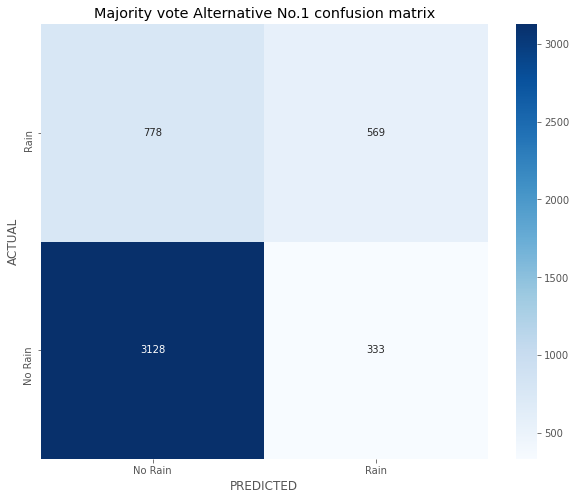

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

conf_matrix.append(confusion_matrix(y_tst, y_mod))
print('\n', classification_report(y_tst, y_mod, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('Majority vote Alternative No.1 confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

## Majority vote Alternative No.2

Assessing raw output

In [ ]:
y_mod = y_mod_CMORPH + y_mod_TAMSAT + y_mod_IMERG

# get index of misclassified images
miss_index = [i for i, y in enumerate(y_tst) if y != (y_mod[i][0]>1.5)]

# visual inspection

print('Number of missclassified days:', len(miss_index), 'out of', len(y_tst))
print(' ')

for i in range(len(miss_index)):

  ix = miss_index[i]

  print(ix, y_tst[ix], y_mod[ix], y_mod[ix][0]>1.5)

Number of missclassified days: 1123 out of 4808
 
3 1.0 [1.4918035] False
5 1.0 [0.3988355] False
6 1.0 [0.94529176] False
7 1.0 [0.42454264] False
13 0.0 [1.6233914] True
19 1.0 [0.43053797] False
21 1.0 [1.3551286] False
24 0.0 [1.8465085] True
27 1.0 [1.3611027] False
31 0.0 [1.5656745] True
35 1.0 [0.34134388] False
40 1.0 [0.9094759] False
60 0.0 [1.6025147] True
61 0.0 [1.7141938] True
63 1.0 [1.4695325] False
65 1.0 [0.78957915] False
69 1.0 [1.3824625] False
75 1.0 [1.4854004] False
77 1.0 [1.3194971] False
78 1.0 [0.55235475] False
82 1.0 [1.0206511] False
86 1.0 [1.4268116] False
87 1.0 [0.820667] False
88 1.0 [0.7514653] False
92 1.0 [0.72023433] False
105 1.0 [1.0310385] False
107 1.0 [0.8588549] False
108 1.0 [1.0648141] False
114 1.0 [1.428162] False
116 0.0 [1.6147537] True
120 1.0 [1.489547] False
121 1.0 [0.9433389] False
122 1.0 [1.2543046] False
125 1.0 [1.4299648] False
127 1.0 [0.65393394] False
132 1.0 [1.4074874] False
134 1.0 [1.0242014] False
136 0.0 [1.9095151

In [ ]:
per = np.sum((y_mod[ miss_index ] >= 0.9) & (y_mod[ miss_index ] <= 2.1)) / len(miss_index) * 100
print('The boarderline (between 0.9 and 2.1) missclassified days are', np.sum((y_mod[ miss_index ] >= 0.9) & (y_mod[ miss_index ] <= 2.1)), 'out of', len(miss_index), 'i.e.', per, '%.')

The boarderline (between 0.9 and 2.1) missclassified days are 759 out of 1123 i.e. 67.58682101513801 %.


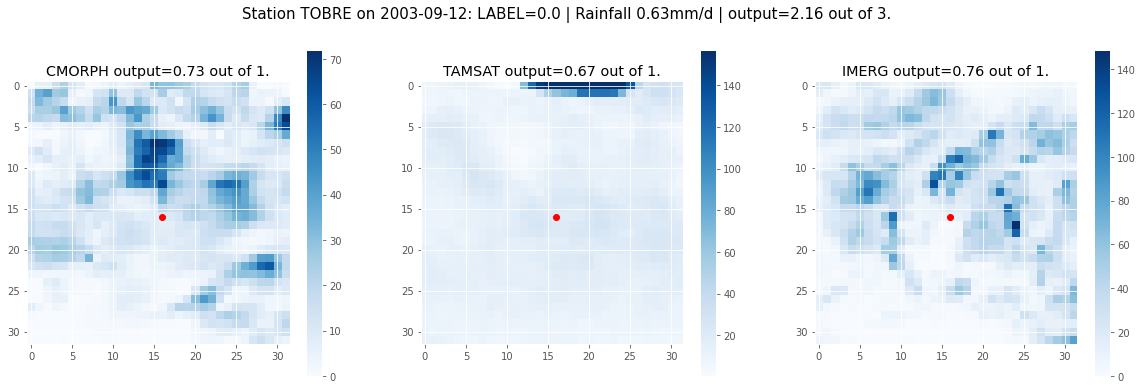

In [ ]:
# select random image
ix = miss_index[random.randint(0, len(miss_index))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]



# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | output={y_mod[ix][0]:.2f} out of 3.', fontsize=15)
plt.subplot()

plt.subplot(131)
img = input_st_CMORPH[ix, :, :] * m_CMORPH
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'CMORPH output={y_mod_CMORPH[ix][0]:.2f} out of 1.')  


plt.subplot(132)
img = input_st_TAMSAT[ix, :, :] * m_TAMSAT
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'TAMSAT output={y_mod_TAMSAT[ix][0]:.2f} out of 1.')   


plt.subplot(133)
img = input_st_IMERG[ix, :, :] * m_IMERG
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'IMERG output={y_mod_IMERG[ix][0]:.2f} out of 1.');  

### Similarity indices of Majority No.2 model's misclassifications:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( input_st_CMORPH[ix, :, :].flatten(), input_st_TAMSAT[ix, :, :].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( input_st_CMORPH[ix, :, :].flatten(), input_st_IMERG[ix, :, :].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( input_st_TAMSAT[ix, :, :].flatten(), input_st_IMERG[ix, :, :].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  -0.01.
Correlation between CMORPH and IMERG:   0.01.
Correlation between TAMSAT and IMERG:   -0.02.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = (( input_st_CMORPH[ix, :, :] // div) ).astype(int)
TAMSAT_classes = (( input_st_TAMSAT[ix, :, :] // div) ).astype(int)
IMERG_classes  = (( input_st_IMERG[ix, :, :]  // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1]
TAMSAT has the following classes:  [ 0  1  2  3  4  5  6 12 17 19 20 21 23 33 35 38 41 47 49]
IMERG  has the following classes:  [0 1 2 3 4 6 7]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (50, 50, 1, 4) and homogeneity: 1.00.
TAMSAT has shape of: (50, 50, 1, 4) and homogeneity: 0.95.
IMERG  has shape of: (50, 50, 1, 4) and homogeneity: 0.98.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (10000,).
TAMSAT has length of: (10000,).
IMERG  has length of: (10000,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.23.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.10.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.19.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = input_st_CMORPH[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = input_st_TAMSAT[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  =  input_st_IMERG[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.20.
CMORPH and IMERG  have a Hamming distance of: 0.28.
TAMSAT and IMERG  have a Hamming distance of: 0.23.


### Confusion matrix

In [ ]:
y_mod = y_mod>1.5  # threshold between 0 and 3

per = sum(y_mod) * 100 / len(y_mod)
print(f'Percentage of modeled wet day: {per[0]:.2f}%.')

Percentage of modeled wet day: 17.55%.



               precision    recall  f1-score   support

     No Rain       0.79      0.91      0.85      3461
        Rain       0.62      0.39      0.48      1347

    accuracy                           0.76      4808
   macro avg       0.71      0.65      0.66      4808
weighted avg       0.75      0.76      0.74      4808



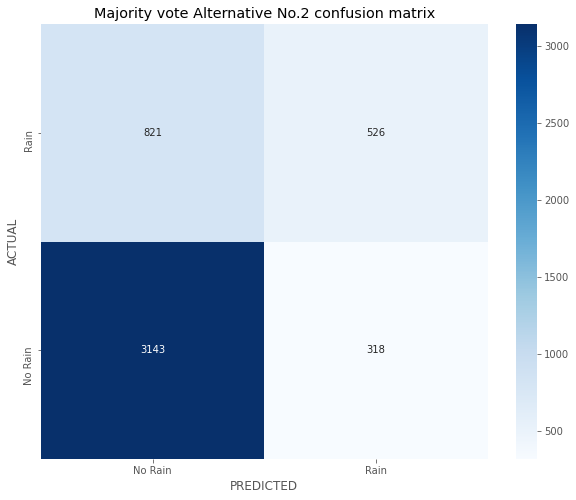

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

conf_matrix.append(confusion_matrix(y_tst, y_mod))
print('\n', classification_report(y_tst, y_mod, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('Majority vote Alternative No.2 confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

### Dry day misclassifications HISTOGRAM

In [ ]:
print('Number of misclassified days:', len(miss_index))

miss_wet = [i for i in (miss_index) if (y_tst[i] == 1.0)]  # misclassified wet days
print('Number of wet days misclassified as dry days:', len(miss_wet))

Number of misclassified days: 1123
Number of wet days misclassified as dry days: 796


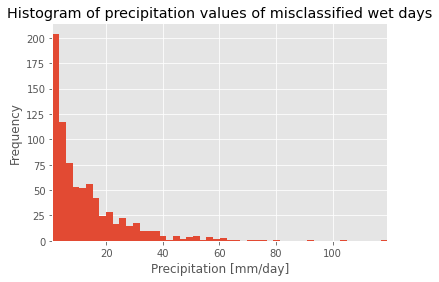

In [ ]:
prec_miss_wet = prec[ ind_tst[miss_wet] ]

plt.title('Histogram of precipitation values of misclassified wet days')
plt.hist(prec_miss_wet, bins=50, range=(1.0, prec_miss_wet.max()))
plt.xlabel('Precipitation [mm/day]')
plt.ylabel('Frequency')
plt.xlim([1.0, prec_miss_wet.max()]);